# Sample Mass-Difference Networks (MDiNs) Notebooks

- Sample_MDiNs_Yeast.ipynb
- Sample_MDiNs_Grapevine.ipynb
- Formula_Networks_Yeast.ipynb

# Sample Mass-Difference Networks (MDiNs) of the Yeast Dataset

This notebook will cover the explorative studies into making networks from a list of masses - Mass-Difference Networks. Each m/z will represent a node. Nodes will be connected if the difference in their masses can be associated to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of its metabolite.

The set of mass differences are called a set of MDBs - Mass-Difference-based Building block.

### Organization of the networks:

- Construction of the files with lists of masses for MDiN construction (MetaNetter plugin of Cytoscape)
- Construction of the transformations (MDBs) list for MDiN construction
- Reading Networks constructed and extraction of some of their main characteristics (full yeast network with either our transformation list - TF - or MetaNetter's - MN)
- Test of the analysis methods used later on with the sample MDiNs and test internal consistency of the networks (in regards to formula assignment)
- Building the sample MDiNs by inducing subgraphs of the complete networks (both TF and MN)
- Building secondary datasets by applying the different network analysis (explanations of some of them) methods to the sample MDiNs - each secondary dataset is identified by the network analysis methods that gave origin to it.
- Unsupervised Statistical Analysis (HCA and K-means clustering) of the secondary datasets (for both TF and MN)
- Supervised Statistical Analysis (Random Forest and PLS-DA), optimization, application and results (only TF)
- Permutation Tests (Supervised Analysis) - only TF
- Test if induced subgraphs of complete networks to build a sample MDiN is identical to building it from scratch.


### Needed imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import metabolinks as mtl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import metabolinks.transformations as transf
import netlsd as nl # Analysis method that was eventually dropped
import itertools

import multianalysis as ma # Developed in this repository

## 2 types of network construction using the MetaNetter 2.0 plugin of Cytoscape, the first one was the one used in the Masters dissertation:

### 1 - NetTF - Using our Transformation List (TF) created here with the transformations mentioned and described later.


### 2 - NetMN - Using the transformation list default to the plugin MetaNetter /MN), only considering most of the small chemical transformations (until a max of 80 m/z).

- Took out Arginine, Arg to Ornitine (aminoacid related) and pyrophosphate (PP) from the MetaNetter list.
- Left 30 different transformations - double from our transformation list, more edges expected in the resulting networks.
- Most of our 15 transformation list is in this list with some exceptions (S, CHOH and NCH), some differences (different de-amination). One different MDB is noteworthy - carbamoylatransferase - where only one can be correct (CONH in our list versus CONH2 in theirs). I believe the ours is more correct as can be seen by the reaction example at: https://www.brenda-enzymes.org/enzyme.php?ecno=2.1.3.11

MetaNetter papers:

- MetaNetter - https://academic.oup.com/bioinformatics/article/24/1/143/205461 
- MetaNetter 2.0 - https://pubmed.ncbi.nlm.nih.gov/29030098/

#### The two transformations lists were analysed. After observation that results from both were similar despite the smaller networks from NetTF (since less transformations were considered), NetTF results were chosen to show in the dissertation since its transformation list is closer to what we wanted to represent with these sample MDiNs in the dissertation.

## Building the MDiNs for the Yeast dataset in Cytoscape

To build the network in Cytoscape we'll need:

1) A list of neutral masses (with masses as float in node attributes).

2) A list of allowed transformations with specific mass differences (that will be in one case ours (TF), and in the other case from the default MetaNetter list (MN) as explained).

## Create list of neutral masses from the m/z peaks of the Yeast dataset to use in Cytoscape to build the different networks

#### Reading Yeast dataset stored and formatted by the MetaboScape 4.0 (Bruker Daltonics) software.

File and formulas given by the MetaboScape software.

In [2]:
def reading_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,
                          prefix_to_drop=None):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    data = data.sort_values(by = 'm/z')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove columns with a given prefix. Eg. 'ENO'
    if prefix_to_drop is not None:
        cols2drop = [c for c in data.columns if c.startswith(prefix_to_drop)]
        data = data.drop(columns=cols2drop)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])

    # optionally, add labels to intensities
    if add_labels is not None:
        data = mtl.add_labels(data, labels=add_labels)
    
    return data

In [3]:
def renamer(colname):
    # Useful to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

leu_enk_name = '555.2692975341 Da' # Bucket label / index of the reference feature

#labels = 'Metadata BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if any strain is removed, change this
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if any strain is removed, change this

In [4]:
# Read in the two files and keep results in dicts 
prefix_to_drop = None # For example, change to 'ENO' to remove ENO strain

# Yeast Dataset used in the dissertation is under the filename '5yeasts_notnorm_2.csv'.

yeast_data = reading_MetScape_file('5yeasts_notnorm_2.csv', 
                                       remove_ref_feat=None,
                                       add_labels=None,
                                       col_renamer=renamer,
                                       prefix_to_drop=None)
yeast_data

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.00,0.00,0.000,5.524132e+05,648388.25,6.080372e+05,6.375496e+05,610135.875,656653.625,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
200.2661522455 Da,201.27343,NaN,NaN,0.00,0.00,575903.125,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
200.2930225885 Da,201.30030,NaN,NaN,1238710.75,1275006.75,1283941.750,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,8.679426e+05,7.015142e+05,7.361217e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,3945019.75,3852594.00,3821208.250,4.204017e+06,4131124.25,4.059027e+06,4.352161e+06,4440771.000,4499343.500,4.345543e+06,4.091804e+06,4.545699e+06,4.248517e+06,4.207834e+06,4.208490e+06
201.1729328725 Da,202.18021,NaN,C11H23NO2,3404298.50,3366785.00,3348790.750,3.672346e+06,3737722.00,3.793184e+06,3.923927e+06,3804580.500,3801558.250,3.835366e+06,3.708862e+06,3.889770e+06,3.635306e+06,3.618243e+06,3.543283e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995.1450511879 Da,2996.15233,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.629427e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2995.8961895300 Da,2996.90347,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,5.415538e+05,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2996.7812722438 Da,2997.78855,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.776696e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


'feature_filter' function:

Used to join different features that share the same formula by adding all of the intensity in each sample for each of those features. The exact m/z that remains corresponds to the feature that contributes the most to the full intensity of the different features that share the formula.

MetaboScape makes different 'buckets' and quantifies them as the features of a dataset. Sometimes, the same peak can be split into multiple buckets (errors in the algorithm). Here, these mistakes that could be identified due to the same formula assignment are rectified. The new bucket of the joined features is the one that contributes most to the full intensity across the samples since it should correspond to the peak "center".

In [5]:
def feature_filter(Spectra):
    """Join all features that share the same formula by addition.
       
       Spectra: Pandas DataFrame (dataset).
       
       Returns: Pandas DataFrame with filtered dataset.
    """

    df = Spectra
    # Variables to store results
    rp = pd.DataFrame(columns = df.columns)
    rep = []
    # Series with number of times each formula appears in the dataset
    form_count = df['Formula'].value_counts()
    a = 0
    
    for i in df['Formula']:
        if pd.isnull(i) == True: # If no formula is assigned to the feature, the feature stays in the new dataset
            rp = rp.append(df.iloc[a,:])

        else: # If a formula is assigned
            if form_count[i] > 1: # If the formula appears more than one time in the dataset
                if i not in rep: # And If it didn't already appear before
                    
                    # Bucket label, name and formula info are the ones from the greater intensity m/z peak (of peaks with the
                    # same formula)
                    peaks = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 1)
                    peaks_idx = peaks.idxmax()
                    info = df.loc[peaks_idx].iloc[:3] # Bucket label, name and formula info
                    
                    # Addition of all m/z peaks intensity with the same formula
                    newrow = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 0)
                    newrow_c = pd.concat([info, newrow], axis = 0) # Join with the m/z peak metadata
                    # m/z peak is from the greater intensity m/z peak (of peaks with the same formula)
                    newrow_c = newrow_c.rename(df.loc[peaks_idx].name)
                    
                    # Append peak with intensity added from all peaks sharing the same formula
                    rp = rp.append(newrow_c)

                    rep.append(i) # Append repeating formulas so this process isn't repeated again for the other m/z peaks

            else:
                rp = rp.append(df.iloc[a,:]) # Append peaks with formulas that aren't repeated in the dataset
        a = a + 1

    # return DataFrame.
    return rp

In [6]:
# Joining rows that have the same formula assigned (with feature_filter) while keeping rows without formulas assigned.
yeast_df = feature_filter(yeast_data)

#Only keeping features that appear in at least 2 samples - Minor peak filtering
yeast_df_temp = transf.keep_atleast(yeast_df.iloc[:,3:].replace({0:np.nan}), min_samples=2)
yeast_df = yeast_df.loc[yeast_df_temp.index]

Make the index the neutral masses of the dataset. Bucket Labels from the MetaboScape software are meant to represent the neutral masses of the identified metabolites, so these will be used - transformation too numbers and removing ' Da'.

In [7]:
#Changing the index to be numbers - list of neutral masses from the bucket lists.
new_index = []
for i in range(len(yeast_df)):
    new_index.append(np.float(yeast_df.index[i][:-3]))
yeast_df.index = new_index

#Only keep peaks below 1000 m/z - Very few peaks above 1000 m/z and mostrly uninformative in the sample MDiNs concept.
yeast_df = yeast_df[yeast_df.iloc[:,0] < 1000]

yeast_df # Final Dataset

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
200.177576,201.18485,Butyl octanoate,C12H24O2,0.000000e+00,0.00,0.000000e+00,5.524132e+05,648388.25,6.080372e+05,6.375496e+05,6.101359e+05,6.566536e+05,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
200.293023,201.30030,NaN,NaN,1.238711e+06,1275006.75,1.283942e+06,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.679426e+05,7.015142e+05,7.361217e+05
201.172770,202.18005,NaN,C11H23NO2,7.349318e+06,7219379.00,7.169999e+06,7.876362e+06,7868846.25,7.852211e+06,8.276088e+06,8.245352e+06,8.300902e+06,8.180909e+06,7.800666e+06,8.435469e+06,7.883823e+06,7.826076e+06,7.751774e+06
201.174973,202.18225,NaN,NaN,1.317429e+06,1552194.75,1.605308e+06,1.035239e+06,965660.50,8.913902e+05,7.434838e+05,6.930808e+05,5.866896e+05,1.057169e+06,1.070222e+06,1.089031e+06,1.583372e+06,1.482374e+06,1.570275e+06
201.979104,202.98638,NaN,C4H10O3S3,5.979574e+05,0.00,5.714457e+05,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937.130478,938.13775,NaN,NaN,0.000000e+00,885170.25,0.000000e+00,8.065278e+05,0.00,0.000000e+00,6.682040e+05,6.535156e+05,5.383812e+05,7.251112e+05,9.439709e+05,9.694091e+05,0.000000e+00,0.000000e+00,7.182504e+05
938.127853,939.13513,NaN,C27H38N16O10S6,6.270084e+05,0.00,8.009592e+05,0.000000e+00,575956.25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.376864e+05,0.000000e+00
985.320748,986.32802,NaN,C51H57NO15P2,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,6.712075e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.547402e+05,0.000000e+00
986.685387,987.69266,NaN,C39H98N14O8S3,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,6.051672e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.263648e+05,0.000000e+00


### Writing a .csv file with the list of masses that will be used to build the MDiN

The file needs to be correctly read by Cytoscape's MetaNetter (and Cytoscape) where the network will be built.

For this, a file with two columns both with the same list of masses (one index, one in the column) will be made. One will correspond to the network nodes names as a 'string'. The other will be an attribute of the corresponding node as a 'float' and will be used in the building process.

In [8]:
pd.DataFrame(yeast_df.index, index=yeast_df.index).to_csv('MassList_YD.csv')

## Making the Transformation File with the Mass-Difference-based Building blocks (MDBs) that are considered relevant to build the MDiN

This file will be in a format accepted by Cytoscape's MetaNetter (.txt separated by tabs) to be considered as a list of transformations (with specific masses) to make the MDiN. 4 columns: 'Label','Formula','Mass','Selected' with mass being the most important.

Formula changes will be put under the 'Label' column and the corresponding set of reactions they represent will be put under 'Formula'. This switch is to make the MDB Influence analysis done later down the line more legible (since 'formula changes' are easier to observe, quickly understood and more concise in relation to long-winded names for set of reactions).

The 'Selected' column will be just a set of True for the MDBs to come in pre-selected in Cytoscape.

Atomic mass of the most common naturally occurring isotope of the more important elements in metabolites and their isotopic abundances

In [9]:
# Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances-https://ciaaw.org/isotopic-abundances.htm/https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
# Isotopic abundances from Pure Appl. Chem. 2016; 88(3): 293–306,
# Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503

chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078) #Carbon 13 isotope
           } 

Functions to transform formulas in string format to dictionary format and from calculate formulas (in dictionary format) exact masses.

Example:

    'String' format: 'C6H1206'
    
    'Dictionary' format: {'C':6, 'H':12, 'O':6}

In [10]:
def formula_process(formula):
    """Transforms a formula in string format into a dictionary."""
    
    #results = pd.DataFrame(np.zeros((1,8)), columns = ['C','H','O','N','S','P','Cl','F'])
    #Empty dictionary to store the results
    results = dict.fromkeys(['C','H','O','N','S','P','Cl','F'], 0)
    count = ''
    letter = None
    
    #Run through the string
    for i in range(len(formula)):
        if formula[i].isupper(): #If i is an uppercase letter then it is an element
            if letter: #Just to account for the first letter in the formula where letter is None
                results[letter] = int(count or 1) #Reached another letter, store previous results and reset count
                count = ''
                
            if i+1 < len(formula): #In case it's a two letter element such as Cl
                if formula[i+1].islower(): #The second letter is always lower case
                    letter = formula[i] + formula[i+1] #Store new 2 letter element
                    continue
                    
            letter = formula[i] #Store new 1 letter element
            
        elif formula[i].isdigit():
            count = count + formula[i] #If number, add number to count
    
    #Store results of the last letter
    results[letter] = int(count or 1)
                    
    return results

In [11]:
def getmass(c,h,o,n,s,p,cl,f):
    "Get the exact mass for any formula."
    massC = chemdict['C'][0] * c
    massH = chemdict['H'][0] * h
    massO = chemdict['O'][0] * o
    massN = chemdict['N'][0] * n
    massS = chemdict['S'][0] * s
    massP = chemdict['P'][0] * p
    massCl = chemdict['Cl'][0] * cl
    massF = chemdict['F'][0] * f 

    massTotal = massC + massH + massO + massN + massS + massP + massCl + massF

    return massTotal

#### Making the transformation file

In [12]:
# Prepare DataFrame
trans_groups = pd.DataFrame(columns=['Label','Formula','Mass','Selected'])
trans_groups = trans_groups.set_index('Label')

# Chemical Formula changes (MDBs considered)
MDBs = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
# Examples of the set of Reactions each MDB represents
labels = ['Hydrogenation','Methylation','Carboxylation/Decarboxylation','Oxygenation','Hydroxymethylation',
          'Formidoylation','Deamination','Tranfer of and -SH group','Carbamoylation','Phosphorylation','Transamination',
          'Sulphation','Formylation','Acetylation','Condensation/Dehydration/Cyclization']

for i in range(len(MDBs)): #Passing through each transformation/MDB

    #Calculate the exact mass of the MDBs
    a = formula_process(MDBs[i])
    MDB_mass = getmass(a['C'],a['H'],a['O'],a['N'],a['S'],a['P'],a['Cl'],a['F'])
    
    # MDBs with removed atoms have to be done manually (formula_process function doesn't account for this since normal
    # formulas don't have a negative amount of atoms of any elements)
    if MDBs[i] == 'O(-NH)':
        MDB_mass = getmass(a['C'],-1,a['O'],-1,a['S'],a['P'],a['Cl'],a['F'])
    elif MDBs[i] == 'NH3(-O)':
        MDB_mass = getmass(a['C'],a['H'],-1,a['N'],a['S'],a['P'],a['Cl'],a['F'])
        
    # Making the row for each transformation
    string = MDBs[i]
    trans_groups.loc[string] = (labels[i], MDB_mass, 'true')

# print(trans_groups)
trans_groups = trans_groups.sort_values(by='Mass')
trans_groups # Transformations DataFrame

,Formula,Mass,Selected
Label,,,
O(-NH),Deamination,0.984016,true
NH3(-O),Transamination,1.031634,true
H2,Hydrogenation,2.015650,true
CH2,Methylation,14.015650,true
O,Oxygenation,15.994915,true
H2O,Condensation/Dehydration/Cyclization,18.010565,true
NCH,Formidoylation,27.010899,true
CO,Formylation,27.994915,true
CHOH,Hydroxymethylation,29.002740,true


In [13]:
#Saving the df as a .txt file in the described format
trans_groups.to_csv('transgroups.txt', header=False, sep='\t')

## Build the Network in Cytoscape using MetaNetter 2.0

The transformation files and the yeast dataset files were used in Cytoscape to build the MDiNs.

Parameters: 1 ppm error allowed for edge establishment.

Discussions on the format of the network built is done later. Also, only one full network (in each case is done) and then subgraphs of it will be used for every sample MDiN instead of building one for each sample (also explained later).

#### 'Net_YD_TF.graphml' - NetTF - Network made with the transformation list built in this notebook.
#### 'Net_YD_MN.graphml' - NetMN - Network made with the MetaNetter transformation list as explained in the beginning of the notebook.

## Reading the network obtained from Cytoscape after MDiN built from MetaNetter

The networks were exported in graphml format that networkX module can read.

- Nodes have a standard 'number' ID instead of the mass which is fortunately stored as the attribute 'mass'. Other attributes stored are irrelevant. 
- Edges among the different attributes have a very useful attribute called 'Transformation' which stores which MDB of the list was used to establish the edge - will be used for MDB Influence analysis.
- Finally, the graph is directed despite only having one connection between any two nodes. Since reactions are bidireccional, they will be transformed to undirected graphs. Below it is shown that the number of edges remains the same between the directed and undirected graph.

Changes that will be made to the network:

- Nodes will be identified by their masses.
- Formulas (when given) will be stored as node attributes.
- Intensities of the node in each sample will be given later to store for each specific subgraph.

### NetTF - Network made with our list of transformations 

In [14]:
# Reading the network made
NetTF_dir = nx.read_graphml('Net_YD_TF.graphml') # Directed Graph
NetTF = NetTF_dir.to_undirected() # Undirected graph

In [15]:
# Info for part of Table 3.4
print('Nº of nodes and edges in directed graph: \t', len(NetTF_dir.nodes()), ',\t',len(NetTF_dir.edges()))
print('Nº of nodes and edges in undirected graph: \t',len(NetTF.nodes()), ',\t',len(NetTF.edges()))

Nº of nodes and edges in directed graph: 	 1893 ,	 810
Nº of nodes and edges in undirected graph: 	 1893 ,	 810


In [16]:
# Making dicts for the new names and new attribute 'Formula' of each node for the network
new_nodes = dict.fromkeys(NetTF.nodes(),0)
formula_attr = dict.fromkeys(NetTF.nodes(),0)

for i,j in nx.get_node_attributes(NetTF,'mass').items(): # i is old name, j is mass/new name
    # print(i,j)
    formula_attr[i] = {'formula':yeast_df.loc[j,'Formula']}
    new_nodes[i] = j

# Setting the new attribute 'Formula' and relabeling nodes
nx.set_node_attributes(NetTF,formula_attr)
NetTF = nx.relabel_nodes(NetTF, mapping=new_nodes)

Plotting the Yeast Dataset MDiN

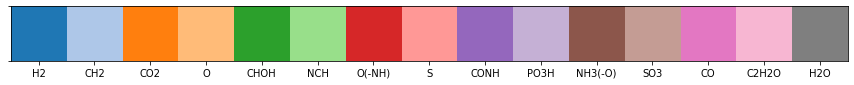

In [17]:
# Colours for each of the MDBs
colours = sns.color_palette('tab20', 15)

unique_MDB = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O','H2O']
MDB_colors = {lbl: c for lbl, c in zip(unique_MDB, colours)}

sns.palplot(MDB_colors.values())
new_ticks = plt.xticks(range(len(unique_MDB)), unique_MDB)

edge_colors =  [MDB_colors[lbl] for lbl in nx.get_edge_attributes(NetTF,'Transformation').values()]

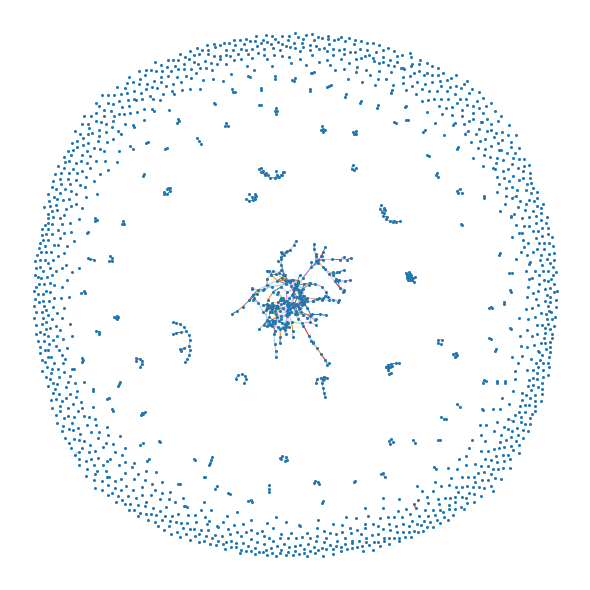

In [18]:
# Drawing the full network for the dataset
# Colouring edges based on the MDB used to establish them
plt.figure(figsize=(8,8))
nx.draw(NetTF, node_size=4, width = 1, edge_color=edge_colors)
plt.show()

#### Small Characterization of the network - Info for part of Table 3.4

In [19]:
# Spread of components
[len(c) for c in sorted(nx.connected_components(NetTF), key=len, reverse=True)][:20]

[275, 18, 17, 16, 14, 14, 11, 9, 7, 6, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4]

In [20]:
# Diameter and Radius of the Network
Main_component = NetTF.subgraph(list(sorted(nx.connected_components(NetTF), key=len, reverse=True)[0]))
print('Diameter of the network:', nx.diameter(Main_component))
print('Radius of the network:', nx.radius(Main_component))

Diameter of the network: 31
Radius of the network: 16


In [21]:
isolated = 0
for i in NetTF.degree():
    if i[1] == 0:
        isolated = isolated + 1

print('Nº of nodes without connections:', isolated)

Nº of nodes without connections: 1219


#### Yeast Dataset Network Analysis with our transformation list (same analysis that will be done for each individual sample network)

5 methods were applied (explanations after when applied to sample MDiNs)

- 3 centrality measures (Degree, Betweenness centrality, Closeness centrality)
- MDB Influence
- GCD-11

A 6 method called NetLSD is here applied that wasn't shown in the dissertation. Like GCD-11, it's an analysis on the topology of the network however it is much less efficiency in both time and discrimination results so it was cut out of the final dissertation.

3 measures of centrality: degree, centrality closeness, betweenness centrality.

In [22]:
# Degree
NetTF_degree = dict(NetTF.degree())
NetTF_degree_all = sorted(NetTF_degree.items(), key=lambda kv: kv[1], reverse = True)
NetTF_degree_all[:10]

[(298.2508367981, 10),
 (299.282447629, 9),
 (283.2875497027, 9),
 (282.2558879557, 9),
 (399.3348641583, 8),
 (284.2351682088, 8),
 (270.2559171241, 8),
 (270.2195089685, 8),
 (268.2401689019, 8),
 (256.2402073027, 8)]

In [23]:
# Betweenness Centrality
NetTF_betw = nx.betweenness_centrality(NetTF)
NetTF_betw_all = sorted(NetTF_betw.items(), key=lambda kv: kv[1], reverse = True)
NetTF_betw_all[:10]

[(340.2016151107, 0.009695616878087163),
 (338.185930009, 0.009597593138970286),
 (382.175747131, 0.0095523135627424),
 (398.1706129689, 0.00950777932933308),
 (384.1550071491, 0.008773159092448187),
 (340.1288250279, 0.00829564224198662),
 (382.2121031609, 0.008265737465054003),
 (382.139364127, 0.008234330895553284),
 (312.0975382871, 0.007080677278646959),
 (326.1131891847, 0.007014639508005302)]

In [24]:
# Closeness Centrality
NetTF_closeness = nx.closeness_centrality(NetTF)
NetTF_closeness_all = sorted(NetTF_closeness.items(), key=lambda kv: kv[1], reverse = True)
NetTF_closeness_all[:10]

[(382.2121031609, 0.01700118299030238),
 (302.2457548807, 0.016986627182947668),
 (284.2351682088, 0.01672882002502772),
 (286.2508146507, 0.016679596931217216),
 (340.2016151107, 0.016582014667515986),
 (298.2508367981, 0.016376707015833988),
 (270.2559171241, 0.016349716151366194),
 (314.2456395099, 0.016196229020149285),
 (328.2613558341, 0.016143515500148798),
 (256.2402073027, 0.016058584014312323)]

#### MDB Influence calculation - Info for part of Suppl. Table 6.3

In [25]:
# MDB Influence in building the network
NetTF_MDBs = dict.fromkeys(MDBs, 0) # MDBs from the transformation list
for i in NetTF.edges():
    NetTF_MDBs[NetTF.edges()[i]['Transformation']] = NetTF_MDBs[NetTF.edges()[i]['Transformation']] + 1

NetTF_MDBs

{'H2': 101,
 'CH2': 152,
 'CO2': 39,
 'O': 100,
 'CHOH': 6,
 'NCH': 27,
 'O(-NH)': 38,
 'S': 13,
 'CONH': 19,
 'PO3H': 36,
 'NH3(-O)': 32,
 'SO3': 11,
 'CO': 78,
 'C2H2O': 62,
 'H2O': 96}

NetLSD - Heat Analysis - See the the diffusion of heat according to the package netlsd (nl) and plot the graph.

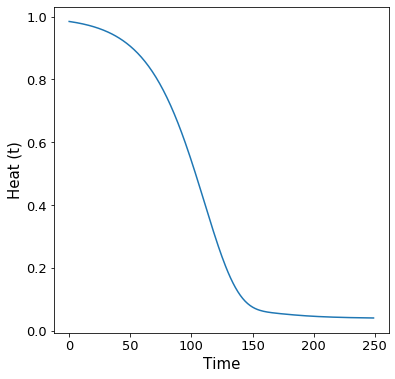

In [26]:
NetTF_heat = nl.heat(NetTF)

# 'Heat' Diffusion of the network
f, ax = plt.subplots(figsize=(6,6))
plt.plot(NetTF_heat)    
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

GCD-11 Analysis - Graphlet Correlation Distance of 11 different non-redundant orbits (maximum of 4-node graphlets)

In [27]:
def calculating_orbits(GG):
    """Calculates the number of times each node of the network is in each possible (non-redundant) orbit in graphlets (maximum
    4 nodes).
    
    Function is not very efficient, all nodes are passed, every graphlet is 'made' for each node present in it so it is made
    multiple times.
    
       GG: networkx graph;
    
       returns: dict; dictionary (keys are the nodes) of dictionaries (keys are the orbits and values are the number of times)
    """
    
    node_orbits = {} # To store results

    for i in GG.nodes():

        node_orbits[i] = {} # To store results
        orbits = node_orbits[i]

        ## size of comp
        # comp = len(nx.node_connected_component(GG, 'c'))

        # 2 node graphlets - orbit 0
        orbits['0'] = GG.degree(i)

        # 3 node graphlets - orbit 1,2 (and 3 redundant)
        node_neigh = list(GG.neighbors(i))

        # orbit 1 and 4 and 6 and 8 and 9
        n_orb = 0
        n_orb4 = 0
        n_orb6 = 0
        n_orb8 = 0
        n_orb9 = 0

        # orbit 1
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j)) # Neighbours of the neighbour j of i
            neigh_neigh.remove(i) # Remove i since i is a neighbour of j
            for common in nx.common_neighbors(GG, i, j):
                neigh_neigh.remove(common) # Remove common neighbours of i and j
            n_orb = n_orb + len(neigh_neigh)


            # orbit 4 and 8
            for n3 in neigh_neigh:
                neigh_neigh_neigh = list(GG.neighbors(n3)) # Neighbours of the neighbour n3 of the neighbour j of i
                #neigh_neigh_neigh.remove(j)
                #if i in neigh_neigh_neigh:
                    #neigh_neigh_neigh.remove(i)     
                for common in nx.common_neighbors(GG, j, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)

                for common in nx.common_neighbors(GG, i, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)
                        # orbit 8
                        if common != j:
                            #print(i,j,n3,common)
                            n_orb8 = n_orb8 + 1/2 # always goes in 2 directions so it will always pass like this

                n_orb4 = n_orb4 + len(neigh_neigh_neigh)
                # print(neigh_neigh_neigh)

            # orbit 6 and 9
            for u,v in itertools.combinations(neigh_neigh, 2):
                if not GG.has_edge(u,v):
                    n_orb6 = n_orb6 + 1
                else:
                    n_orb9 = n_orb9 + 1         

        orbits['1'] = n_orb

        # orbit 2 and 5
        n_orb = 0
        n_orb5 = 0
        for u,v in itertools.combinations(node_neigh, 2):
            if not GG.has_edge(u,v):
                n_orb = n_orb + 1

                # orbit 5
                neigh_u = list(GG.neighbors(u))
                neigh_u.remove(i)
                for common in nx.common_neighbors(GG, i, u):
                    neigh_u.remove(common)

                neigh_v = list(GG.neighbors(v))
                neigh_v.remove(i)
                for common in nx.common_neighbors(GG, i, v):
                    neigh_v.remove(common)

                for common in nx.common_neighbors(GG, v, u):
                    if common in neigh_u:
                        neigh_u.remove(common)
                    if common in neigh_v:
                        neigh_v.remove(common) 

                n_orb5 = n_orb5 + len(neigh_u)
                n_orb5 = n_orb5 + len(neigh_v)

        orbits['2'] = n_orb

        # 4 node graphlets - orbit 4,5,6,7,8,9,10,11 (and 12,13,14 redundant)

        # orbit 4
        orbits['4'] = n_orb4

        # orbit 5
        orbits['5'] = n_orb5

        # orbit 6
        orbits['6'] = n_orb6

        # orbit 7 and 11
        n_orb = 0
        n_orb11 = 0
        for u,v,j in itertools.combinations(node_neigh, 3):
            n_edge = [GG.has_edge(a,b) for a,b in itertools.combinations((u,v,j), 2)]
            #print(sum(n_edge))
            if sum(n_edge) == 0:
                n_orb = n_orb + 1
            elif sum(n_edge) == 1:
                n_orb11 = n_orb11 + 1

        orbits['7'] = n_orb

        # orbit 8
        orbits['8'] = int(n_orb8)

        # orbit 9
        orbits['9'] = n_orb9

        # orbit10
        n_orb = 0
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for u,v in itertools.combinations(neigh_neigh, 2):
                if sum((GG.has_edge(i,u), GG.has_edge(i,v))) == 1:
                    if not GG.has_edge(u,v):
                        n_orb = n_orb + 1

        orbits['10'] = n_orb

        # orbit 11
        orbits['11'] = n_orb11
    
    return node_orbits

In [28]:
# Counting the number of the number of times each node has each of the 11 orbits, make it a DataFrame
NetTF_GCD = calculating_orbits(NetTF)
NetTF_GCD_df = pd.DataFrame.from_dict(NetTF_GCD).T

# Graphlet Correlation Matrix (Spearman correlation between the different columns - orbits)
NetTF_CorrMat = stats.spearmanr(NetTF_GCD_df,axis=0)[0]

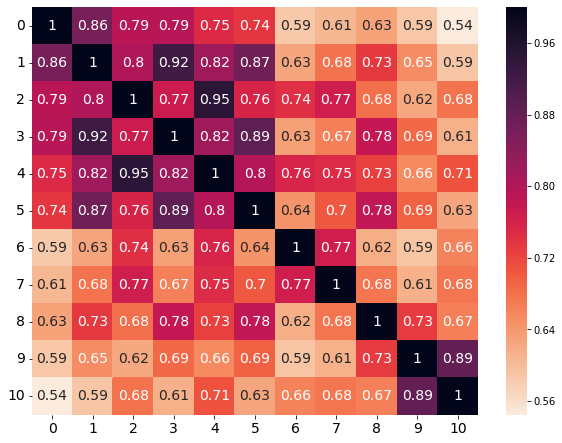

In [29]:
# Representing the Graphlet Correlation Matrix
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(NetTF_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

### NetMN (MetaNetter) - Network made with MetaNetter's list of transformations

In [30]:
#Reading the network
NetMN_dir = nx.read_graphml('Net_YD_MN.graphml')
NetMN = NetMN_dir.to_undirected()

In [31]:
print('Nº of nodes and edges in directed graph: \t', len(NetMN_dir.nodes()), ',\t',len(NetMN_dir.edges()))
print('Nº of nodes and edges in undirected graph: \t',len(NetMN.nodes()), ',\t',len(NetMN.edges()))

Nº of nodes and edges in directed graph: 	 1893 ,	 1215
Nº of nodes and edges in undirected graph: 	 1893 ,	 1215


In [32]:
# Making dicts for the new names and new attribute 'Formula' of each node for the network
new_nodes = dict.fromkeys(NetMN.nodes(),0)
formula_attr = dict.fromkeys(NetMN.nodes(),0)

for i,j in nx.get_node_attributes(NetMN,'mass').items(): # i is old name, j is mass/new name
    #print(i,j)
    formula_attr[i] = {'formula':yeast_df.loc[j,'Formula']}
    new_nodes[i] = j

# Setting the new attribute 'Formula' and relabeling nodes
nx.set_node_attributes(NetMN,formula_attr)
NetMN = nx.relabel_nodes(NetMN, mapping=new_nodes)

Plotting the Yeast Dataset MDiN

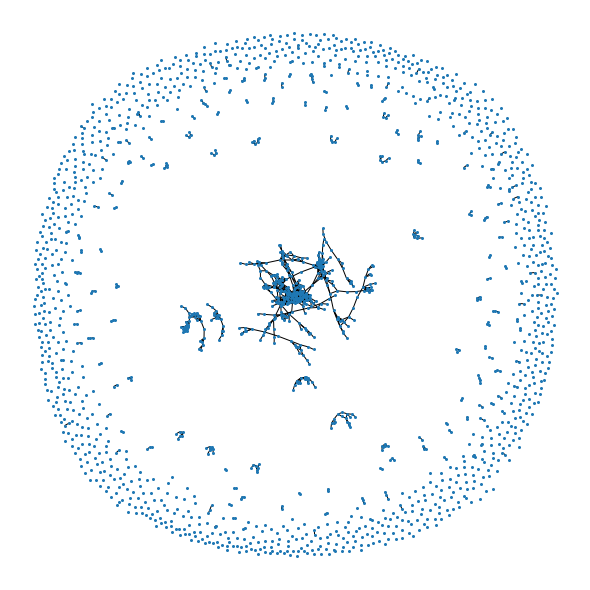

In [33]:
#Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(NetMN, node_size=4, width = 1)#, edge_color=edge_colors)
plt.show()

Small Characterization of the network

In [34]:
# Spread of components
[len(c) for c in sorted(nx.connected_components(NetMN), key=len, reverse=True)][:20]

[307, 21, 20, 20, 19, 17, 17, 13, 12, 8, 8, 6, 6, 6, 6, 5, 5, 5, 5, 4]

In [35]:
#Diameter and Radius of the Network
Main_component = NetMN.subgraph(list(sorted(nx.connected_components(NetMN), key=len, reverse=True)[0]))
print('Diameter of the network:', nx.diameter(Main_component))
print('Radius of the network:', nx.radius(Main_component))

Diameter of the network: 29
Radius of the network: 15


In [36]:
isolated = 0
for i in NetMN.degree():
    if i[1] == 0:
        isolated = isolated + 1

print('Nº of nodes without connections:', isolated)

Nº of nodes without connections: 1051


#### Yeast Dataset Network Analysis with MetaNetter's transformation list (same analysis that will be done for each individual sample network)

5 methods were applied (explanations after when applied to sample MDiNs)

- 3 centrality measures (Degree, Betweenness centrality, Closeness centrality)
- MDB Influence
- GCD-11

A 6 method called NetLSD is here applied that wasn't shown in the dissertation. Like GCD-11, it's an analysis on the topology of the network however it is much less efficiency in both time and discrimination results so it was cut out of the final dissertation.

3 measures of centrality: degree, centrality closeness, betweenness centrality.

In [37]:
# Degree
NetMN_degree = dict(NetMN.degree())
NetMN_degree_all = sorted(NetMN_degree.items(), key=lambda kv: kv[1], reverse = True)
NetMN_degree_all[:10]

[(327.3136893021, 13),
 (254.2246098628, 13),
 (399.3348641583, 12),
 (328.2613558341, 12),
 (299.282447629, 12),
 (283.2875497027, 12),
 (270.2559171241, 12),
 (268.2401689019, 12),
 (256.2402073027, 12),
 (242.2245493667, 12)]

In [38]:
# Betweenness Centrality
NetMN_betw = nx.betweenness_centrality(NetMN)
NetMN_betw_all = sorted(NetMN_betw.items(), key=lambda kv: kv[1], reverse = True)
NetMN_betw_all[:10]

[(382.175747131, 0.005595973969467472),
 (188.1047773826, 0.0055744509421303675),
 (356.1237549523, 0.005270312836359937),
 (268.0713226384, 0.005025907669045468),
 (333.2151434908, 0.004968395756989975),
 (276.1572942597, 0.0047973460464200285),
 (354.1444622407, 0.004687129149136859),
 (296.1026126414, 0.004475895803636645),
 (410.2070680253, 0.004361156035427214),
 (203.115666118, 0.004000189293329388)]

In [39]:
# Closeness Centrality
NetMN_closeness = nx.closeness_centrality(NetMN)
NetMN_closeness_all = sorted(NetMN_closeness.items(), key=lambda kv: kv[1], reverse = True)
NetMN_closeness_all[:10]

[(302.2457548807, 0.027571301536450207),
 (242.2245493667, 0.02754061561376078),
 (328.2613558341, 0.026911629286529702),
 (256.2402073027, 0.026882393404632332),
 (270.2559171241, 0.02682411179291497),
 (382.2121031609, 0.02678056615688751),
 (314.2456395099, 0.02675161419347466),
 (284.2351682088, 0.026536453757602208),
 (268.2401689019, 0.026536453757602208),
 (299.282447629, 0.026465500672688835)]

MDB Influence calculation

In [40]:
# MDB Influence in building the network
NetMN_MDBs = dict.fromkeys(set(nx.get_edge_attributes(NetMN, 'Transformation').values()), 0)
for i in NetMN.edges():
    NetMN_MDBs[NetMN.edges()[i]['Transformation']] = NetMN_MDBs[NetMN.edges()[i]['Transformation']] + 1

NetMN_MDBs

{'Acetyl CoA + H2O (-CoASH)': 46,
 'PolyamineReactionA': 6,
 'glyoxylate (-H2O)': 25,
 'Polyamine Synthase': 26,
 'sulfate (-H2O)': 11,
 'methanol (-H2O)': 152,
 'Inorganic Phosphate': 5,
 'tertiary amine': 17,
 '"acetylation (-H2O), ketol group (-H2O)"': 62,
 'primary amine': 9,
 'C2H2': 79,
 'Ethanolamine (-H2O)': 3,
 'Mevalonate-5-pyrophosphate decarboxylase ': 14,
 'hydroxylation (-H)': 100,
 'Glycine': 29,
 'Formic Acid (-H2O)': 78,
 'hydrogenation/dehydrogenation': 101,
 'urea addition (-H)': 7,
 'Carboxylation': 39,
 '"Ethanol (-H2O), ethyl addition (-H2O)"': 133,
 'condensation/dehydration': 96,
 'acetylation (-H)': 6,
 'isoprene addition (-H)': 10,
 'Aminotransferase': 32,
 'CHO2': 4,
 'carbamoyl P transfer (-H2PO4)': 4,
 'CO2H2': 53,
 'acetone (-H)': 6,
 'phosphate': 36,
 'secondary amine': 26}

#### Some notes:

- Most major MDBs that establish edges here are also present in our 15 list.
- "Ethanol (-H2O), ethyl addition (-H2O)" establishes 133 edges and is the 2nd transformation with higher edge count below CH2 (152) and is not present (since it is just two methyl groups).
- Other important transformations not present are "acetylation (-H2O), ketol group (-H2O)" with 62 edges and 'C2H2' with 79 edges.

NetLSD - Heat Analysis - See the the diffusion of heat according to the package netlsd (nl) and plot the graph.

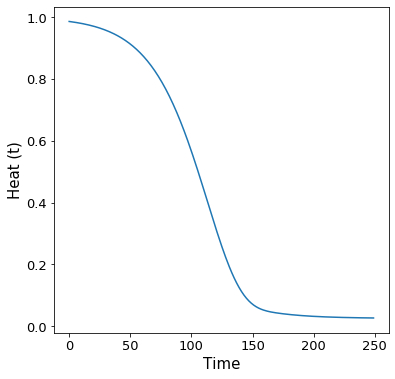

In [41]:
NetMN_heat = nl.heat(NetMN)

# 'Heat' Diffusion of the network
f, ax = plt.subplots(figsize=(6,6))
plt.plot(NetMN_heat)    
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets)

In [42]:
# Counting the number of the number of times each node has each of the 11 orbits, make it a DataFrame
NetMN_GCD = calculating_orbits(NetMN)
NetMN_GCD_df = pd.DataFrame.from_dict(NetMN_GCD).T

# Graphlet Correlation Matrix (Spearman correlation between the different columns - orbits)
NetMN_CorrMat = stats.spearmanr(NetMN_GCD_df,axis=0)[0]

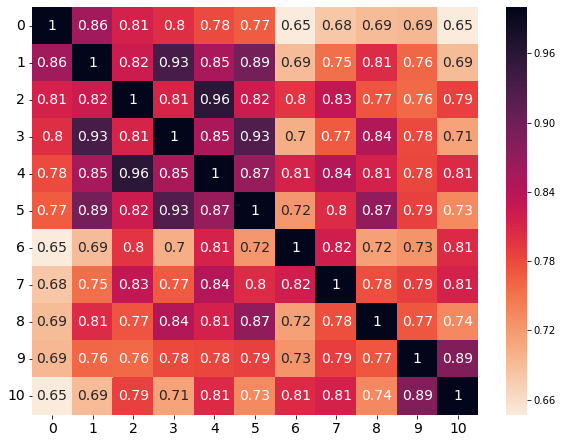

In [43]:
# Representing the Graphlet Correlation Matrix
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(NetMN_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

### Fast Comparison between networks made with the two lists in terms of number of edges

In [44]:
print('NetTF edges:', len(NetTF.edges()), 'with 15 transformations.')
print('NetMN edges:', len(NetMN.edges()), 'with 30 transformations.')
print(len(NetMN.edges())/len(NetTF.edges())*100 - 100, '% more edges with double (100%) the number of MDBs.')

NetTF edges: 810 with 15 transformations.
NetMN edges: 1215 with 30 transformations.
50.0 % more edges with double (100%) the number of MDBs.


### Comparisons to Formula_Networks.ipynb

The full yeast dataset network built in Formula_Networks had 1528 nodes with 665 edges. We can see that there is an increase in edge numbers with this method that also have more nodes since they consider m/z and not formulas, however that increase is not that substantial. Furthermore, the more important part of the networks - the main components, which are much bigger than any others, are all very similar in size, 263 in the Formula_Networks to 275 in TF and 307 in MN. 

With this similarity in the main component, we expect for both approaches to give similar results.

## Network consistency for formulas

This is basically to see if while propagating the formulas already assigned with the MetaboScape, the different connections of the network built by MetaNetter had internal consistency. That is, if we start with two different formulas assigned present in the same network component, all the nodes of that component would have the same formula whether it was propagated through one of the formulas assigned nodes or the other.

As we can see below, there wasn't a need to do an in-depth test of this since very early it became clear that this internal consistency could not be observed in these networks since:

1) Same formula on multiple nodes - the presence of very similar m/z made it so the same node used the same transformation to two different nodes (this was actually observed in the drawn network in Cytoscape).

2) Multiple formulas on multiple nodes depending on the starting formula - if we start assigning formulas based on two different nodes that had previously assigned formulas, some of these two nodes led to conflicting attributions for the nodes in the same component.

Only a short test was needed to reach this conclusion that is explained after some needed functions here.


#### Some functions needed from other notebooks to ease the analysis - deformulator (to turn string format formulas datasets into dataframe format formulas) and formulator (to turn dataframe format formulas into string format formulas).

In [45]:
def deformulator(df):
    """Transforms a set of formulas in string format into a DataFrame with columns corresponding to each element.
       Element order: Order of the elements in the formulas.
    """
    
    filtered_formulas = df['Formula'].dropna() #Dropping empty cells (without formulas)
    
    formula = {}
    for i in filtered_formulas:
        if 'C(13)' in i:
            #Ignores C(13) formulas - the C12 formulas already exist
            continue
        else:
            #Transform the string representing the formula into a dictionary and store all results in a dictionary
            formula[i] = formula_process(i)
            #formulas.loc[filtered_formulas[filtered_formulas == i].index[0]] = formula_process(i).iloc[0]
            
    #Transforming the dictionary of dictionaries into the pretended dataframe
    formula_df = pd.DataFrame.from_dict(formula).T
    formula_df = formula_df.replace({np.nan:0}).astype(int) #Replace nan values when an element doesn't appear in a formula for 0
    
    return formula_df

#Adapted from FTMSVisualization
def formulator(c,h,o,n,s,p,f=0,cl=0,c13=0):
    """Transforms element counts to a readable formula in string format. Element order: C, H, N, O, S, P, F, Cl (and C(13))."""
    
    formula = "C"+str(c)+"H"+str(h)

    if cl > 0:
        if cl > 1:
            formula = formula + "Cl" + str(cl)
        else:
            formula = formula + "Cl"
    if f > 0:
        if f > 1:
            formula = formula + "F" + str(f)
        else:
            formula = formula + "F"
    if n > 0:
        if n > 1:
            formula = formula + "N" + str(n)
        else:
            formula = formula + "N"
    if o > 0:
        if o > 1:
            formula = formula + "O" + str(o)
        else:
            formula = formula + "O"
    if p > 0:
        if p > 1:
            formula = formula + "P" + str(p)
        else:
            formula = formula + "P"
    if s > 0:
        if s > 1:
            formula = formula + "S" + str(s)
        else:
            formula = formula + "S"
    if c13 > 0:
        if c13 > 1:
            formula = formula + "C(13)" + str(s)
        else:
            formula = formula + "C(13)"
            
    return formula

#### Short internal consistency test

1) Take only the nodes/masses with the most "reliable" formulas, that is, formulas that have a "Name" associated in the yeast dataset that were annotated with the HMDB or YMDB.

2) Assign formulas only to the direct neighbors (not the entire component) of those nodes based on the transformation attribute of the edge that links them.

3) See the formulas that were assigned to the different nodes by this method.

This was done only for the TF network and its conclusions can be extrapolated to the MN dataset.

In [46]:
# Making the dataframe formulas dataset for the yeast dataset
formulas_df = deformulator(yeast_df)
formulas_df

,C,H,O,N,S,P,Cl,F
C12H24O2,12,24,2,0,0,0,0,0
C11H23NO2,11,23,2,1,0,0,0,0
C4H10O3S3,4,10,3,0,3,0,0,0
C9H17NO4,9,17,4,1,0,0,0,0
C8H17N3O3,8,17,3,3,0,0,0,0
...,...,...,...,...,...,...,...,...
C26H49O28PS3,26,49,28,0,3,1,0,0
C27H38N16O10S6,27,38,10,16,6,0,0,0
C51H57NO15P2,51,57,15,1,0,2,0,0
C39H98N14O8S3,39,98,8,14,3,0,0,0


In [47]:
# Making a dataframe formulas dataset of the trasnformations used to build the TF network
grouping_df = deformulator(pd.DataFrame(MDBs, index=MDBs,columns=['Formula'])).astype(int)
# Rows for transformation where elements are subtracted have to be done manually
grouping_df.loc['O(-NH)'] = [0,-1,1,-1,0,0,0,0]
grouping_df.loc['NH3(-O)'] = [0,3,-1,1,0,0,0,0]

grouping_df

,C,H,O,N,S,P,Cl,F
H2,0,2,0,0,0,0,0,0
CH2,1,2,0,0,0,0,0,0
CO2,1,0,2,0,0,0,0,0
O,0,0,1,0,0,0,0,0
CHOH,1,1,1,0,0,0,0,0
NCH,1,1,0,1,0,0,0,0
O(-NH),0,-1,1,-1,0,0,0,0
S,0,0,0,0,1,0,0,0
CONH,1,1,1,1,0,0,0,0
PO3H,0,1,3,0,0,1,0,0


In [48]:
store_formulas = dict.fromkeys(yeast_df.index, ()) # Store formulas given to each node
#j1_store = [] # This was for when I was gonna do a full test before I saw that it wasn't needed

for i in yeast_df['Name'].dropna().index: # Only considering m/z with Formula and Name

    original_node = formulas_df.loc[yeast_df.loc[i,'Formula']] # Taking dataframe format formula of the node
    
    for j in NetTF.edges([i]): # For all edges that the original node with a name establishes
        transf = grouping_df.loc[NetTF.edges()[j]['Transformation']] # Transformation with a dataframe format
        
        # Make the formula assigned to the other end of the edge
        if j[1] > j[0]: # If the original node has a smaller m/z, then the transfer group is added to it.
            f = original_node + transf
        else: # If it has a bigger m/z, the transfer group is subtracted from it.
            f = original_node - transf
        #print(original_node)
        
        # Transform the formula into a string format and store it in store_formulas if not already there
        form = formulator(c=f['C'], h=f['H'], o=f['O'], n=f['N'], s=f['S'], p=f['P'], cl=f['Cl'])
        if form not in store_formulas[j[1]]:
            store_formulas[j[1]] = store_formulas[j[1]] + (form,)
        
        #j1_store.append(j[1])

In [49]:
# If none of those 2 major points (same formula given to two peaks or multiple formulas given to one peak) happens, 
# it would be a good initial sign and a full test would be made afterwards, however that doesn't happen multiple times:
store_formulas

{200.1775759522: ('C12H24O2',),
 200.2930225885: (),
 201.1727696159: ('C11H23NO2',),
 201.1749731669: (),
 201.9791043208: (),
 203.0816321195: (),
 203.0817397293: (),
 203.115666118: ('C9H17NO4',),
 203.1268992141: (),
 203.4294251531: (),
 204.0747018724: (),
 204.0785989915: (),
 204.8962034267: (),
 204.896374784: (),
 206.0006536605: (),
 206.9591108939: (),
 206.9592544933: (),
 207.3614515972: (),
 207.3617415684: (),
 207.3619285113: (),
 207.694954647: (),
 207.6962167146: (),
 208.0260229865: (),
 208.02739415: (),
 208.0710454509: (),
 208.1464085422: ('C13H20O2',),
 210.0868442668: (),
 212.0451454245: (),
 212.0904898815: (),
 212.091008594: ('C8H12N4O3',),
 212.9949604459: (),
 213.0943646429: (),
 213.9554270326: (),
 213.9556022868: (),
 213.9902969943: (),
 213.9991080166: (),
 213.9992655181: (),
 214.1205863993: (),
 214.1932519061: ('C13H26O2',),
 215.0558713098: ('C5H14NO6P',),
 216.0974284751: (),
 217.1314940618: ('C10H19NO4',),
 218.0101891075: (),
 218.010381

For example, same formula attributed to two peaks (although the masses are very very similar, so it makes some sense):

229.0714548763: ('C6H16NO6P',)

229.0715630133: ('C6H16NO6P',)

Even more troubling is the amount of peaks with multiple formulas for example: 243.0871382835 has two formulas assigned

In [50]:
store_formulas[243.0871382835]

('C9H13N3O5', 'C7H18NO6P')

In [51]:
# See its edges
NetTF.edges([243.0871382835])

EdgeDataView([(243.0871382835, 257.1028750516), (243.0871382835, 244.0711842658), (243.0871382835, 229.0715630133), (243.0871382835, 229.0714548763)])

In [52]:
# 4 edges: let's see the original formulas of each of the other nodes in yeast_df
print(257.1028750516, ':', yeast_df.loc[257.1028750516]['Formula'], yeast_df.loc[257.1028750516]['Name'])
print(244.0711842658, ':', yeast_df.loc[244.0711842658]['Formula'], yeast_df.loc[244.0711842658]['Name'])
print(229.0715630133, ':', yeast_df.loc[229.0715630133]['Formula'], yeast_df.loc[229.0715630133]['Name'])
print(229.0714548763, ':', yeast_df.loc[229.0714548763]['Formula'], yeast_df.loc[229.0714548763]['Name'])

257.1028750516 : C8H20NO6P Glycerophosphocholine
244.0711842658 : C9H12N2O6 Beta-pseudouridine
229.0715630133 : C6H16NO6P nan
229.0714548763 : nan nan


In [53]:
# The third and fourth ones don't have a name so they can be ignored
# Now let's see the transformation attribute of each of these edges
print(257.1028750516, ':', NetTF.edges()[(243.0871382835, 257.1028750516)]['Transformation'])
print(244.0711842658, ':', NetTF.edges()[(243.0871382835, 244.0711842658)]['Transformation'])

257.1028750516 : CH2
244.0711842658 : O(-NH)


In [54]:
# Now let's see what formula each assigned to the peak 243.0871382835
print(257.1028750516, ':', 243.0871382835, '-', 'C7H18NO6P') # Higher mass on original node - subtraction
print(244.0711842658, ':', 243.0871382835, '-', 'C9H13N3O6') # Higher mass on original node - subtraction

257.1028750516 : 243.0871382835 - C7H18NO6P
244.0711842658 : 243.0871382835 - C9H13N3O6


In [55]:
# Different formulas despite the very similar masses
print('C7H18NO6P:', getmass(c=7,h=18,n=1,o=6,s=0,p=1,cl=0,f=0))
print('C9H13N2O6:', getmass(c=9,h=13,n=3,o=5,s=0,p=0,cl=0,f=0))

C7H18NO6P: 243.0871742956
C9H13N2O6: 243.0855205256


This difference would mean that starting with either Glycerophosphocholine (257.1028750516) feature or Beta-pseudouridine (244.0711842658) feature would lead to the different formula assignments in the whole component.

#### Conclusions:

- These problems invalidates the formula assignment that could be made with this type of approach without further tinkering (keep formula assignments and usual elemental ratios in mind when building the network). 
- However, the fact that the analysis can be done without formula assignment means that it can also be done to the grapevine dataset, opening new possibilities with this approach.

### Why only a network for each dataset instead of a network for each sample?

The different sample networks here will be made of subgraphs of the full dataset network made (one for each transformation list) with only the masses that are present in each sample. This can be done since edges only depend on the two nodes they connect. 

As was observed at the end of this notebook, this (inducing subgraphs from the complete full networks) is identical to building the networks from scratch (they are isomorphic).

## Mass-Difference Sample Networks Analysis and Comparison - NetTF and NetMN

Here the Sample MDiNs will be analysed by different metrics and a "secondary" dataset will be built for each  different metric with features related to the metric used.

#### Creating the networks by inducing subgraphs of the main networks NetTF and NetMN (each has a dictionary)

Also adding the intensity to store in the respective nodes of each sample network.

In [56]:
# Making all the graphs and storing
TF = {}
MN = {}

for j in yeast_df.columns[3:]:
    TF[j] = NetTF.subgraph(yeast_df[yeast_df.loc[:,j] != 0].index)
    MN[j] = NetMN.subgraph(yeast_df[yeast_df.loc[:,j] != 0].index)    
    
    # Storing intensity of feature in sample on the nodes
    intensity_attr = dict.fromkeys(TF[j].nodes(),0)
    for i,n in nx.get_node_attributes(TF[j],'mass').items():
        intensity_attr[i] = {'intensity':yeast_df.loc[n,j]}
    nx.set_node_attributes(TF[j],intensity_attr)
    nx.set_node_attributes(MN[j],intensity_attr)
    
    #print(len(TF[j].nodes()),len(MN[j].nodes()))

Storing all the different analysis measures

In [57]:
# Storage for the centrality measures results
TF_degree = {} 
TF_betw = {}
TF_closeness = {}

# Storage for the information on MDB influence, size of components formed and heat diffusion of the
# different graphs according to NetLSD
TF_MDBs = {}
TF_components = {}
TF_heat = {}


# Storage for the centrality measures results
MN_degree = {} 
MN_betw = {}
MN_closeness = {}

# Storage for the information on MDB influence, size of components formed and heat diffusion of the
# different graphs according to NetLSD
MN_MDBs = {}
MN_components = {}
MN_heat = {}


# Storing the main centrality measures, size of the different components, MDB influence and heat diffusions
for j in TF:
    # NetTF
    # Centrality measures
    TF_degree[j] = dict(TF[j].degree())
    TF_betw[j] = nx.betweenness_centrality(TF[j])
    TF_closeness[j] = nx.closeness_centrality(TF[j])
    
    # MDB_influence
    TF_MDBs[j] = dict.fromkeys(MDBs, 0) # MDBs from the transformation list
    for i in TF[j].edges():
        TF_MDBs[j][TF[j].edges()[i]['Transformation']] = TF_MDBs[j][TF[j].edges()[i]['Transformation']] + 1
    
    # Only get the components > 1 (more than just an isolated node)
    TF_components[j] = [len(c) for c in sorted(nx.connected_components(TF[j]), key=len, reverse=True) if len(c) > 1]
    
    # NetLSD
    TF_heat[j] = nl.heat(TF[j])
    
    # NetMN
    # Centrality measures
    MN_degree[j] = dict(MN[j].degree())
    MN_betw[j] = nx.betweenness_centrality(MN[j])
    MN_closeness[j] = nx.closeness_centrality(MN[j])
    
    # MDB_influence
    MN_MDBs[j] = dict.fromkeys(set(nx.get_edge_attributes(NetMN, 'Transformation').values()), 0)
    for i in MN[j].edges():
        MN_MDBs[j][MN[j].edges()[i]['Transformation']] = MN_MDBs[j][MN[j].edges()[i]['Transformation']] + 1
    
    # Only get the components > 1 (more than just an isolated node)
    MN_components[j] = [len(c) for c in sorted(nx.connected_components(MN[j]), key=len, reverse=True) if len(c) > 1]
    
    # NetLSD
    MN_heat[j] = nl.heat(MN[j])

### 3 Centrality measures, MDB Influence, Heat Diffusion and GCD-11 analysis

The 3 first network analysis methods focus on the characteristics of each node and each node is kept as a feature of a new dataset while the last 3 methods focus on the overall topology and structure of the network reducing drastically the number of features. By analysing in both manners, we obtained a more complete analysis of the networks and can be more confident in our results. 

### Obtaining the dataframes for analysis

#### Centrality measures dataframes

The analysis of each centrality measure is completely independent of each other.

In [58]:
degree_TF = pd.DataFrame.from_dict(TF_degree).replace({np.nan:0})
betw_TF = pd.DataFrame.from_dict(TF_betw).replace({np.nan:0.0})
closeness_TF = pd.DataFrame.from_dict(TF_closeness).replace({np.nan:0.0})

In [59]:
degree_MN = pd.DataFrame.from_dict(MN_degree).replace({np.nan:0})
betw_MN = pd.DataFrame.from_dict(MN_betw).replace({np.nan:0.0})
closeness_MN = pd.DataFrame.from_dict(MN_closeness).replace({np.nan:0.0})

In [60]:
# Example of a centrality measure dataframe
degree_TF

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
414.204274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414.246500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420.345069,1.0,2.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0
422.324318,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
494.381834,2.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815.972819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
821.716889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638.107293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
314.171709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### MDB Influence Dataframes

Transform the dictionary of dictionaries with the MDB Influence stats into a dataframe. Now, it can be analysed together with the binary dataframes made above. The analysis performed will be the same than for the rest of dataframes, however, for this dataframe the distance measure used in hierarchical clustering is euclidean and not a binary measure such as the jaccard distance since this dataframe is not binary.

#### What is "MDB Influence" in this context?

Each MDB that represents a set of chemical reactions has a value attached in every network built. This number corresponds to the amount of edges that were established between two formulas that used this MDB, that is, the amount of times one of the set of chemical reactions can transform a formula into another (a metabolite into another).

This value then should represent the importance of the MDB in establishing the network when compared to the rest of the groups. The bigger the value, the higher the impact of that MDB in establishing the network. To normalize the comparison between sample MDiNs with a lot and few edges, the MDBs values are normalized by the total number of edges established in the network (and multiplied by 100). Then, they represent the % of edges each MDB helped establish.

Here we test if the importance of these MDBs in establishing the overall network is characteristic of the strain of the sample.

We also can see the overall influence of each MDB in building the networks. 

In [61]:
MDBs_TF = pd.DataFrame.from_dict(TF_MDBs)
MDBs_MN = pd.DataFrame.from_dict(MN_MDBs)
MDBs_TF

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
H2,33,36,42,44,52,54,23,32,35,40,39,44,34,29,32
CH2,66,74,75,66,80,82,39,48,49,53,58,65,58,70,76
CO2,16,14,18,18,16,18,18,19,19,17,16,19,15,17,17
O,37,46,46,44,52,55,23,38,37,50,47,51,35,39,43
CHOH,0,1,0,0,0,0,0,0,0,2,1,0,1,0,0
NCH,11,13,11,9,10,9,4,8,8,8,10,9,6,4,7
O(-NH),11,12,11,11,12,17,6,9,8,12,10,12,8,11,10
S,4,5,4,3,4,2,2,2,1,3,4,4,4,5,6
CONH,6,7,5,8,6,6,6,6,6,4,4,4,6,4,4
PO3H,19,20,23,17,17,16,5,7,6,8,10,10,12,13,11


In [62]:
# Normalization of the MDBs
MDBs_TF = MDBs_TF/MDBs_TF.sum()*100
MDBs_MN = MDBs_MN/MDBs_MN.sum()*100
MDBs_TF

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
H2,11.458333,10.650888,12.244898,13.880126,14.016173,14.136126,13.142857,13.278008,13.944223,13.513514,13.494810,13.968254,13.492063,10.247350,10.666667
CH2,22.916667,21.893491,21.865889,20.820189,21.563342,21.465969,22.285714,19.917012,19.521912,17.905405,20.069204,20.634921,23.015873,24.734982,25.333333
CO2,5.555556,4.142012,5.247813,5.678233,4.312668,4.712042,10.285714,7.883817,7.569721,5.743243,5.536332,6.031746,5.952381,6.007067,5.666667
O,12.847222,13.609467,13.411079,13.880126,14.016173,14.397906,13.142857,15.767635,14.741036,16.891892,16.262976,16.190476,13.888889,13.780919,14.333333
CHOH,0.000000,0.295858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.675676,0.346021,0.000000,0.396825,0.000000,0.000000
NCH,3.819444,3.846154,3.206997,2.839117,2.695418,2.356021,2.285714,3.319502,3.187251,2.702703,3.460208,2.857143,2.380952,1.413428,2.333333
O(-NH),3.819444,3.550296,3.206997,3.470032,3.234501,4.450262,3.428571,3.734440,3.187251,4.054054,3.460208,3.809524,3.174603,3.886926,3.333333
S,1.388889,1.479290,1.166181,0.946372,1.078167,0.523560,1.142857,0.829876,0.398406,1.013514,1.384083,1.269841,1.587302,1.766784,2.000000
CONH,2.083333,2.071006,1.457726,2.523659,1.617251,1.570681,3.428571,2.489627,2.390438,1.351351,1.384083,1.269841,2.380952,1.413428,1.333333
PO3H,6.597222,5.917160,6.705539,5.362776,4.582210,4.188482,2.857143,2.904564,2.390438,2.702703,3.460208,3.174603,4.761905,4.593640,3.666667


#### NetLSD - Heat Diffusion Dataframe

#### Heat Diffusion distances calculation

Use the heat function from the netlsd Python package to compute the "heat diffusion" of each graph as explained in 'NetLSD: Hearing the Shape of a Graph' (https://arxiv.org/pdf/1805.10712.pdf) for each function storing the results in the dict G_heat (done above while making the graphs).

Calculate then every pairwise "distance" between the diffusion of two graphs and store in the dataframe G_heat_df.

Each "heat diffusion" is calculated by the heat function and each distance is calculated by the compare function. The dataset obtained is then a distance matrix where 

The objective is to see if this heat diffusion is characteristic of the different strains since it should represent the overall architecture of each graph at both a local and global level.

The distance matrix obtained will be used as the secondary dataset in this case (which is not ideal). The features of each sample are then the distance to the other samples.

In [63]:
heat_TF = pd.DataFrame(index=TF_heat.keys(), columns=TF_heat.keys())

for g in TF_heat:
    for i in TF_heat:
        heat_TF.loc[g,i] = nl.compare(TF_heat[g], TF_heat[i])

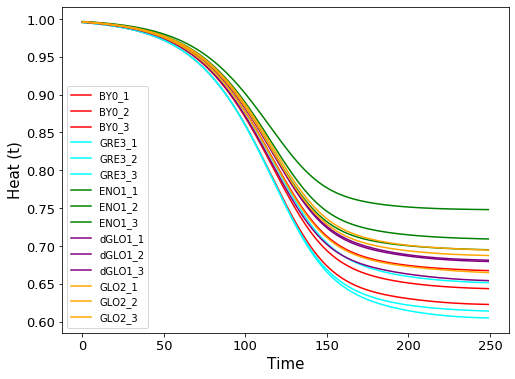

In [64]:
f, ax = plt.subplots(figsize=(8,6))
  
# Heat Diffusion of the sample networks
for i in TF_heat:
    if i.startswith('BY'):
        plt.plot(TF_heat[i], color = 'red')
    if i.startswith('GRE3'):
        plt.plot(TF_heat[i], color = 'cyan')
    if i.startswith('ENO1'):
        plt.plot(TF_heat[i], color = 'green')
    if i.startswith('dGLO1'):
        plt.plot(TF_heat[i], color = 'purple')
    if i.startswith('GLO2'):
        plt.plot(TF_heat[i], color = 'orange')
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(TF_heat.keys())
plt.show()

In [65]:
heat_MN = pd.DataFrame(index=MN_heat.keys(), columns=MN_heat.keys())

for g in MN_heat:
    for i in MN_heat:
        heat_MN.loc[g,i] = nl.compare(MN_heat[g], MN_heat[i])

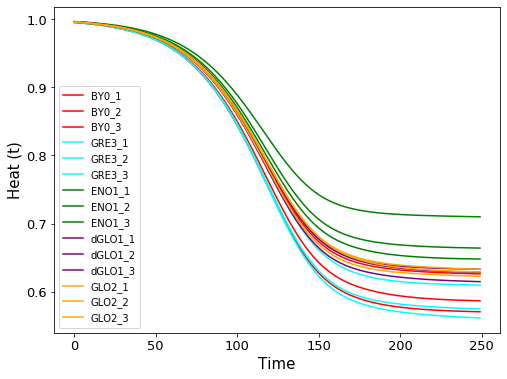

In [66]:
f, ax = plt.subplots(figsize=(8,6))

# Heat Diffusion of the sample networks
for i in MN_heat:
    if i.startswith('BY'):
        plt.plot(MN_heat[i], color = 'red')
    if i.startswith('GRE3'):
        plt.plot(MN_heat[i], color = 'cyan')
    if i.startswith('ENO1'):
        plt.plot(MN_heat[i], color = 'green')
    if i.startswith('dGLO1'):
        plt.plot(MN_heat[i], color = 'purple')
    if i.startswith('GLO2'):
        plt.plot(MN_heat[i], color = 'orange')
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(MN_heat.keys())
plt.show()


### GCD-11 Analysis - Graphlet Correlation Distance of 11 different non-redundant orbits (maximum of 4-node graphlets) 

#### Very quick explanation

This methods considers 11 of the 15 possible orbits (since the other 4 are redundant - 3, 12, 13, 14) of 2 to 4-node graphlets - check image below. Nodes with the same colour in the same graphlet are 'automorphic' in the sense that they are in the 'same' relative position.  5-node graphlets were excluded to diminish dependencies between graphlets which add noise (according to the authors - 1st paper below). With these orbits, we can build a Graphlet Degree Vector for each node that is composed by the number of times a node is present in each of the 11 types of orbits. These are the rows of a Dataframe with 11 columns (for one network). This is what the calculating_orbits function does (except it returns a dict of dicts instead of a dataframe).

From this dataframe, the spearman correlation between each pair of the 11 columns is calculated to generate a 11x11 matrix - the Graphlet Correlation Matrix (GCM). The GCM is symmetric so only one half of the matrix is informative. This, according to the authors, is the signature of the network topology by this method (since networks with different kinds of connections/topologies will have different patterns of orbits and therefore correlations - stored in G_corrMat. The usual distance calculation between the different 'signatures' can then give the distance between the different networks which is ideal to build directly a dendrogram.

However, unlike what was done for the heat diffusion, we don't want a distance matrix to be our dataset for supervised methods. So, a dataset was made where the GCM signature of each network was fully maintained by making a columns from the informative half of the GCM where each row has the name 'n-m' where n and m are the names of orbits and the value in that row is the spearman correlation between those two orbits in the network. This makes it so every network is reduced to a dataset of just 60 features that simbolize the topology of said network.

Useful papers for detailed explanations: 
- Revealing the Hidden Language of Complex Networks - GCD-11 - probably the best one
- Uncovering Biological Network Function via Graphlet Degree Signatures - some details on graphlet signatures
- Comparing methods for comparing networks - many different methods

<img src="Graphlets.png" width="800">

In [67]:
TF_CorrMat = {}
for i in TF:
    # For 1 network
    orbits_t = calculating_orbits(TF[i]) # Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T # Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] # Calculating spearman correlation to obtain 11x11 signature of the network - GCM
    TF_CorrMat[i] = np.triu(corrMat_ar) # Both parts of the matrix are equal, so reducing the info to the upper triangle

In [68]:
# Pulling the signature orbit n (u) - orbit m (v) correlations from the upper triangular matrix of the GCM
TF_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] # orbit names

# Making the signature into a column of the secondary dataset
for i in TF_CorrMat:
    samp_col = {}
    for u in range(len(TF_CorrMat[i])):
        for v in range(u+1, len(TF_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = TF_CorrMat[i][u,v]
        TF_CorrMat_df[i] = samp_col

# Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_TF = pd.DataFrame.from_dict(TF_CorrMat_df)
#corrMat_TF

In [69]:
MN_CorrMat = {}
for i in MN:
    #For 1 network
    orbits_t = calculating_orbits(MN[i]) # Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T # Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] # Calculating spearman correlation to obtain 11x11 signature of the network - GCM
    MN_CorrMat[i] = np.triu(corrMat_ar) # Both parts of the matrix are equal, so reducing the info to the upper triangle

In [70]:
# Pulling the signature orbit n (u) - orbit m (v) correlations from the upper triangular matrix of the GCM
MN_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] #orbit names

# Making the signature into a column of the secondary dataset
for i in MN_CorrMat:
    samp_col = {}
    for u in range(len(MN_CorrMat[i])):
        for v in range(u+1, len(MN_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = MN_CorrMat[i][u,v]
        MN_CorrMat_df[i] = samp_col

# Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_MN = pd.DataFrame.from_dict(MN_CorrMat_df)
corrMat_MN

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
0-1,0.893740,0.900941,0.904380,0.927035,0.913098,0.921561,0.855534,0.900681,0.887226,0.903314,0.894953,0.907983,0.906664,0.896629,0.891468
0-2,0.841828,0.855751,0.868208,0.868099,0.875261,0.876967,0.775656,0.829641,0.814079,0.847396,0.844684,0.868741,0.843317,0.833173,0.841187
0-4,0.816608,0.839882,0.839768,0.865271,0.852775,0.866281,0.750006,0.794922,0.814793,0.843209,0.812679,0.845267,0.846225,0.815653,0.791803
0-5,0.805915,0.818563,0.836289,0.841022,0.845088,0.847506,0.744353,0.795091,0.786343,0.817539,0.812884,0.832103,0.821002,0.804113,0.808650
0-6,0.763053,0.756485,0.750487,0.817345,0.820688,0.828513,0.695809,0.737054,0.751408,0.786146,0.788485,0.783805,0.772050,0.754483,0.763157
0-7,0.641068,0.655474,0.648804,0.694270,0.704787,0.711118,0.580249,0.608681,0.630460,0.666281,0.672709,0.676967,0.647075,0.636686,0.649890
0-8,0.702954,0.676790,0.681079,0.759908,0.759557,0.748018,0.588265,0.630291,0.632972,0.710388,0.696106,0.742592,0.693233,0.701718,0.698404
0-9,0.691391,0.684286,0.677609,0.738495,0.763691,0.766879,0.631828,0.668184,0.664940,0.738863,0.739489,0.738110,0.683852,0.690432,0.695563
0-10,0.727740,0.716901,0.732807,0.746149,0.761290,0.773078,0.644751,0.674862,0.682265,0.743676,0.745977,0.762255,0.709604,0.702323,0.725688
0-11,0.678918,0.671507,0.685194,0.692604,0.723452,0.734489,0.584455,0.614167,0.626486,0.704609,0.700788,0.729429,0.662829,0.662638,0.674214


### Global metadata for consistency between tables and plots

Finally, only now are the labels of each group added making the dataframe a CDL Accessor.

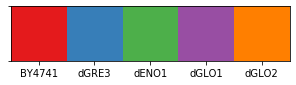

In [71]:
# Adding the labels of the groups to each DataFrame
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split()

mtl.add_labels(degree_TF, labels = labels)
mtl.add_labels(betw_TF, labels = labels)
mtl.add_labels(closeness_TF, labels = labels)
mtl.add_labels(MDBs_TF, labels = labels)
mtl.add_labels(heat_TF, labels = labels)
mtl.add_labels(corrMat_TF, labels = labels)

mtl.add_labels(degree_MN, labels = labels)
mtl.add_labels(betw_MN, labels = labels)
mtl.add_labels(closeness_MN, labels = labels)
mtl.add_labels(MDBs_MN, labels = labels)
mtl.add_labels(heat_MN, labels = labels)
mtl.add_labels(corrMat_MN, labels = labels)

# Useful variables for later on
sample_names = degree_TF.cdl.samples
all_labels = degree_TF.cdl.labels
unique_labels = degree_TF.cdl.unique_labels

# Colours representing each yeast strain
# customize these colors
#colours = cm.get_cmap('nipy_spectral', 5)(range(5))
colours = sns.color_palette('Set1', 9)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

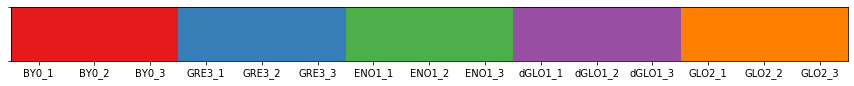

In [72]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Unsupervised and Supervised Statistical Analysis 

### Unsupervised Statistical Analysis

### (Agglomerative) Hierarchical Cluster Analysis 

HCA analysis and plotting dendrograms based on the secondary datasets built - degree, betweenness centrality, closeness centrality, MDB influence, NetLSD (already a distance matrix in this case, the distance matrix is used since no better option is available) and GCD-11 for both the TF and NM networks.

Dendrograms were plotted with Euclidian distance metric and UPGMA linkage.

In [73]:
def plot_dendogram(Z, title='', color_threshold = None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    plt.rcParams['lines.linewidth'] = 1.3
    
    fig = plt.figure(figsize=(10,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=13, above_threshold_color='b', leaf_rotation=30,
                         color_threshold = color_threshold)#,  orientation='left')
    
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 16)
    xlbls = ax.get_xmajorticklabels()

    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])
    

### NetTF - Transformation List - Yeast - Part of Fig. 3.9 and Suppl. Fig 6.9

Centrality measures Dendrograms

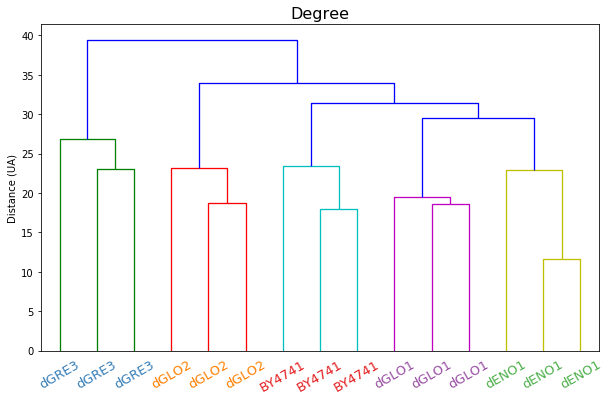

In [74]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
degree_TF_df_dist = dist.pdist(degree_TF.T, metric='euclidean')
Z_degree_TF = hier.linkage(degree_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_TF, degree_TF_df_dist)[0]

# Plot the dendrogram
title = f'Degree'
plot_dendogram(Z_degree_TF, title)
#plt.savefig('Net-Dendro-YD-Degree')

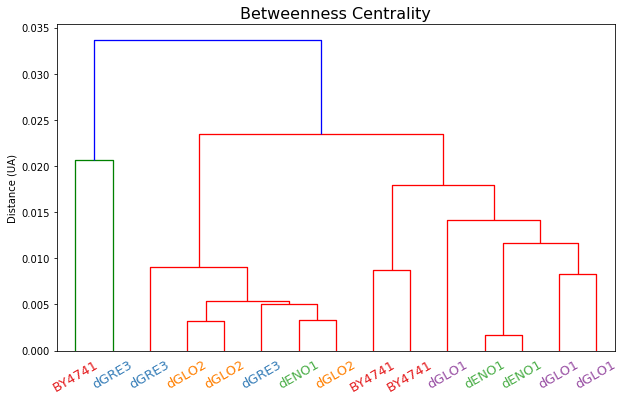

In [75]:
# Calculating the distance matrix between the samples in the secondary dataset and build the linkage matrix of the HCA
betw_TF_df_dist = dist.pdist(betw_TF.T, metric='euclidean')
Z_betw_TF = hier.linkage(betw_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_TF, betw_TF_df_dist)[0]

# Plot the dendrogram
title = f'Betweenness Centrality'
plot_dendogram(Z_betw_TF, title)
#plt.savefig('Net-Dendro-YD-Betw')

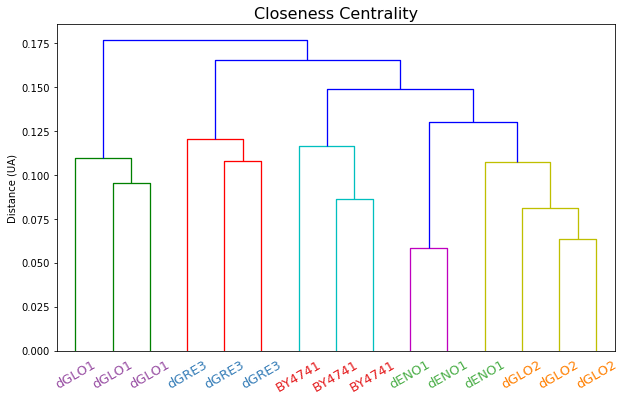

In [76]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
closeness_TF_df_dist = dist.pdist(closeness_TF.T, metric='euclidean')
Z_closeness_TF = hier.linkage(closeness_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_TF, closeness_TF_df_dist)[0]

# Plot the dendrogram
title = f'Closeness Centrality'
plot_dendogram(Z_closeness_TF, title)
#plt.savefig('Net-Dendro-YD-Close')

MDB Influence Dendrogram

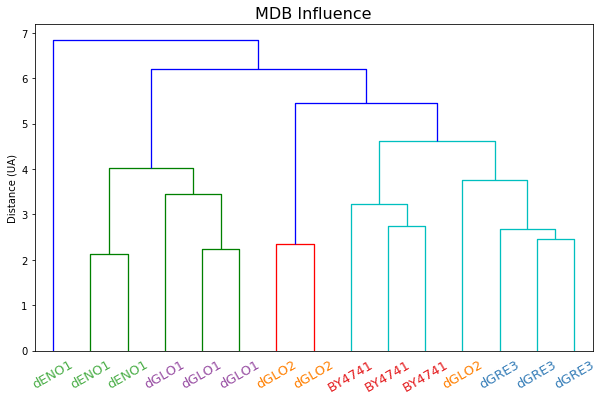

In [77]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
MDBs_TF_df_dist = dist.pdist(MDBs_TF.T, metric='euclidean')
Z_MDBs_TF = hier.linkage(MDBs_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_MDBs_TF, MDBs_TF_df_dist)[0]

# Plot the dendrogram
title = f'MDB Influence'
plot_dendogram(Z_MDBs_TF, title)
#plt.savefig('Net-Dendro-YD-Group')

Heat Diffusion Dendrogram

In [78]:
heat_TF_df_short = dist.squareform(heat_TF) # Condensing the distance matrix
# Be careful when running these 3 cells, running them multiple times can lead to kernel dying.

In [79]:
# Build the linkage matrix of the HCA
Z_heat_TF = hier.linkage(heat_TF_df_short, method='average')

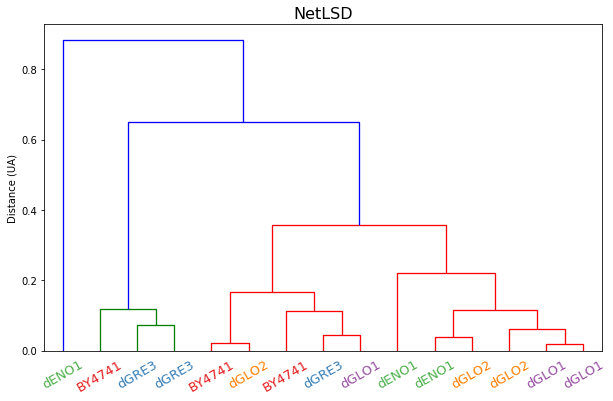

In [80]:
# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_heat_TF, heat_TF_df_short)[0]

# Plot the dendrogram
title = f'NetLSD'
plot_dendogram(Z_heat_TF, title)

GCD-11 Dendrogram

In [81]:
# Calculating the distance matrix (between the samples) of the secondary dataset

# Both ways are equal - 2nd you get the condensed distance matrix right away

# 1st way
#corrMat_df_dist = pd.DataFrame(index=G_CorrMat.keys(), columns=G_CorrMat.keys())

#for g in G_CorrMat:
#    for i in G_CorrMat:
#        corrMat_df_dist.loc[g,i] = np.linalg.norm(G_CorrMat[g]-G_CorrMat[i])
#corrMat_df_dist

# 2nd way
corrMat_TF_df_dist = dist.pdist(corrMat_TF.T)

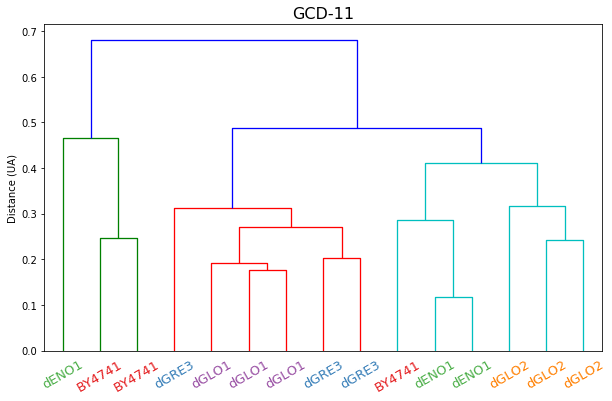

In [82]:
# Build the linkage matrix of the HCA
Z_GCD_TF = hier.linkage(corrMat_TF_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_TF, corrMat_TF_df_dist)[0]

# Plot the dendrogram
title = f'GCD-11'
plot_dendogram(Z_GCD_TF, title)
#plt.savefig('Net-Dendro-YD-GCD')

### NetMN - MetaNetter (Transformation List) - Yeast

Centrality measures Dendrograms

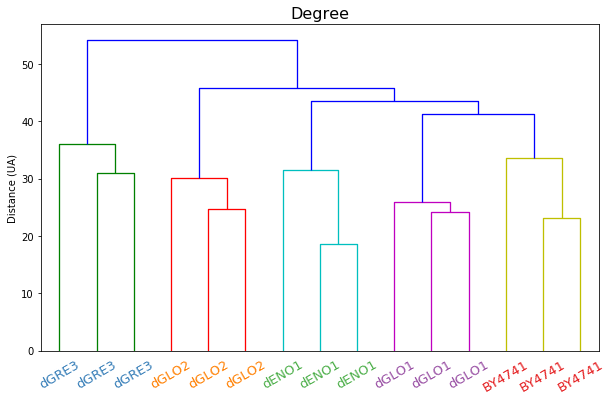

In [83]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
degree_MN_df_dist = dist.pdist(degree_MN.T, metric='euclidean')
Z_degree_MN = hier.linkage(degree_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_MN, degree_MN_df_dist)[0]

# Plot the dendrogram
title = f'Degree'
plot_dendogram(Z_degree_MN, title)

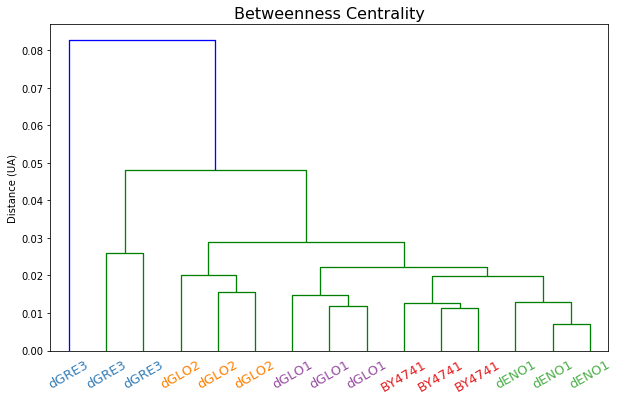

In [84]:
# Calculating the distance matrix between the samples in the secondary dataset and build the linkage matrix of the HCA
betw_MN_df_dist = dist.pdist(betw_MN.T, metric='euclidean')
Z_betw_MN = hier.linkage(betw_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_MN, betw_MN_df_dist)[0]

# Plot the dendrogram
title = f'Betweenness Centrality'
plot_dendogram(Z_betw_MN, title)

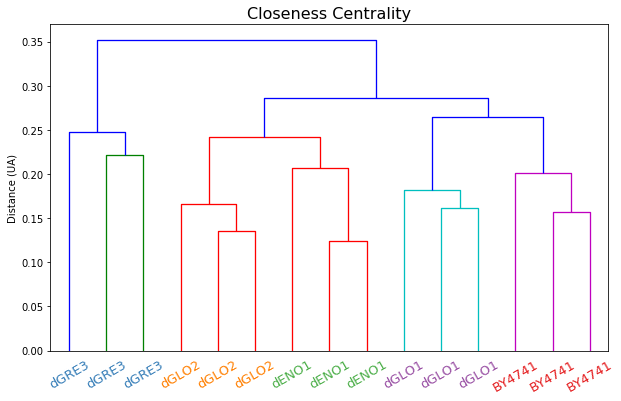

In [85]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
closeness_MN_df_dist = dist.pdist(closeness_MN.T, metric='euclidean')
Z_closeness_MN = hier.linkage(closeness_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_MN, closeness_MN_df_dist)[0]

# Plot the dendrogram
title = f'Closeness Centrality'
plot_dendogram(Z_closeness_MN, title)

MDB Influence Dendrogram

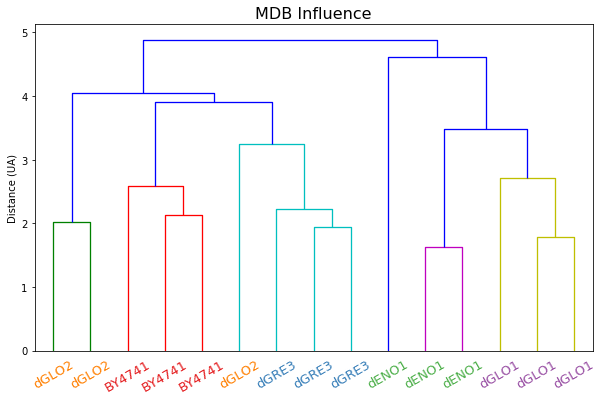

In [86]:
# Calculating the distance matrix (between the samples) of the secondary dataset and build the linkage matrix of the HCA
MDBs_MN_df_dist = dist.pdist(MDBs_MN.T, metric='euclidean')
Z_MDBs_MN = hier.linkage(MDBs_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_MDBs_MN, MDBs_MN_df_dist)[0]

# Plot the dendrogram
title = f'MDB Influence'
plot_dendogram(Z_MDBs_MN, title)

Heat Diffusion Dendrogram

In [87]:
heat_MN_df_short = dist.squareform(heat_MN) # Condensing the distance matrix
# Be careful when running these 3 cells, running them weirdly can lead to kernel dying for unknown reasons.

In [88]:
# Build the linkage matrix of the HCA
Z_heat_MN = hier.linkage(heat_MN_df_short, method='average')

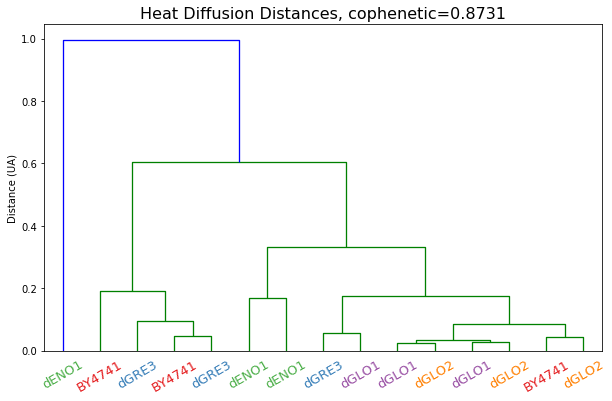

In [89]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_heat_MN, heat_MN_df_short)[0]

# Plot the dendrogram
title = f'Heat Diffusion Distances, cophenetic={coph:.4f}'
plot_dendogram(Z_heat_MN, title)

GCD-11 Dendrogram

In [90]:
# Calculating the distance matrix (between the samples) of the secondary dataset
corrMat_MN_df_dist = dist.pdist(corrMat_MN.T)

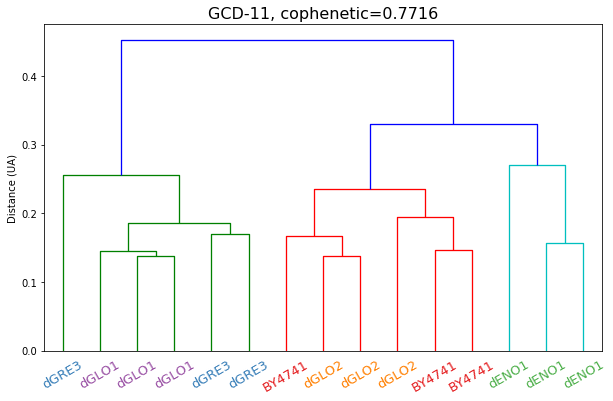

In [91]:
# Build the linkage matrix of the HCA
Z_GCD_MN = hier.linkage(corrMat_MN_df_dist, method='average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_MN, corrMat_MN_df_dist)[0]

# Plot the dendrogram
title = f'GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z_GCD_MN, title)

### Comparing HCA Discrimination - Info for Part of Fig. 3.9

Using 3 different metrics explained in the dissertation:

- Discrimination Distance
- Correct Clustering Percentage
- Correct First Cluster

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct (Group) Clustering definition - samples of a group all clustered together before any other sample clustered with a sample of said group.

In [92]:
# Linkage Matrices of the different dendrograms built from the secondary datasets
Z = (Z_degree_TF, Z_betw_TF, Z_closeness_TF, Z_MDBs_TF, Z_heat_TF, Z_GCD_TF,
    Z_degree_MN, Z_betw_MN, Z_closeness_MN, Z_MDBs_MN, Z_heat_MN, Z_GCD_MN)

# Condensed distance matrices between samples for each of the secondary datasets
dists = (degree_TF_df_dist, betw_TF_df_dist, closeness_TF_df_dist, MDBs_TF_df_dist, heat_TF_df_short, corrMat_TF_df_dist,
        degree_MN_df_dist, betw_MN_df_dist, closeness_MN_df_dist, MDBs_MN_df_dist, heat_MN_df_short, corrMat_MN_df_dist)

# Names for each of the secondary datasets - Nomenclature: Analysis Method_Identification of original dataset (TF or MN)
colnames = ['Degree_TF', 'Betweenness_TF', ' Closeness_TF', 'MDB Influence_TF', 'NetLSD_TF', 'GCD-11_TF',
           'Degree_MN', 'Betweenness_MN', ' Closeness_MN', 'MDB Influence_MN', 'NetLSD_MN', 'GCD-11_MN']

In [93]:
disc_average = np.zeros((1,12)) # Discrimination Distance Storing
disc_correct = np.zeros((1,12)) # Correct Clustering Percentage Storing
disc_1stclust = np.zeros((1,12)) # Correct First Cluster Percentage Storing

for i in range(len(Z)):
    data = degree_TF
    
    # Discrimination Distance and Correct Clustering Percentage
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  # all samples have the same order
    disc_average[0,i] = discrim[0]
    #disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] # all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    # Correct First Cluster Percentage
    disc_1stclust[0,i] = ma.good_first_cluster_fraction(data, Z[i]) # all samples have the same order
    
# Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['Discriminatio Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 5, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_1stclust = pd.DataFrame(disc_1stclust * 100, index = ['% correct 1st cluster'], columns = colnames) # Transforming into %s

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discriminatio Distance']).T, disc_average.iloc[:,6:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,6:]], axis = 1)
disc_1stclust = pd.concat([disc_1stclust.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct 1st cluster']).T, disc_1stclust.iloc[:,6:]], axis = 1)

#### Representation of the results from the three metrics with heatmaps

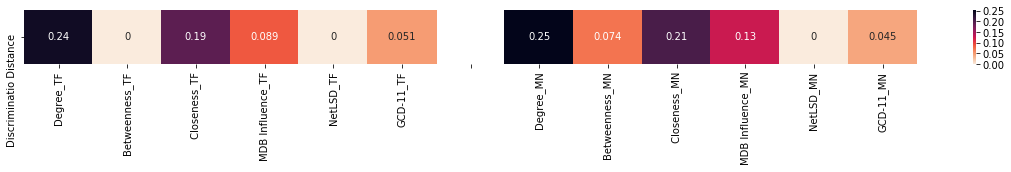

In [94]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

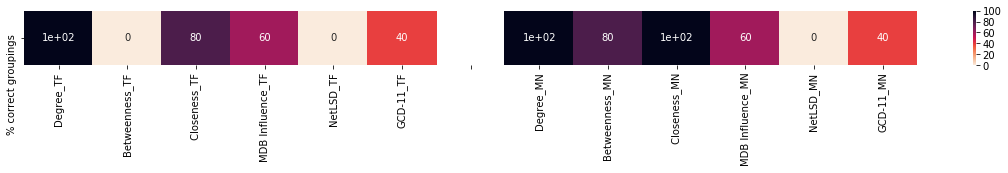

In [95]:
# Correct Clustering percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

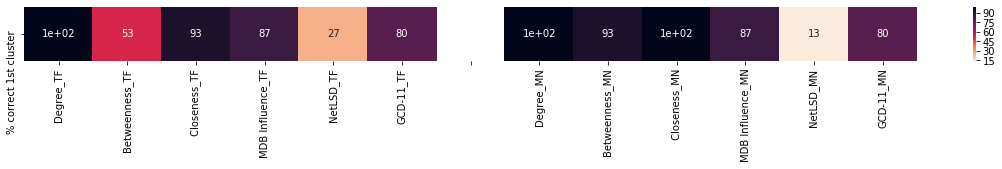

In [96]:
# Correct First Cluster percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_1stclust, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

In [97]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering analysis and how samples are separated 

Use of the sci-kit learn Python package - sklearn. 

Cluster number equal to the amount of groups. Default parameters except number of clusters.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters and existence of local minima.

In [98]:
# Setting the K-means Clustering
Kmean = skclust.KMeans(n_clusters=5)

In [99]:
# Fitting the K-means clustering analysis to a dataset
a = Kmean.fit(degree_TF.T)
a.inertia_ # Results of the function to be minimized by the K-means algorithm_
# sum of squared distances of the samples to the cluster centers

2377.3333333333335

In [100]:
# Example of the cluster mades with the K-means clustering analysis. Samples identified by their groups
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{3: ['BY4741', 'BY4741', 'BY4741'],
 1: ['dGRE3', 'dGRE3', 'dGRE3'],
 0: ['dENO1', 'dENO1', 'dENO1'],
 4: ['dGLO1', 'dGLO1', 'dGLO1'],
 2: ['dGLO2', 'dGLO2', 'dGLO2']}

### K-means clustering applied to all networks

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group.

In [101]:
# Datasets to apply the K-means Clustering Analysis
Data = (degree_TF, betw_TF, closeness_TF, MDBs_TF, heat_TF, corrMat_TF,
       degree_MN, betw_MN, closeness_MN, MDBs_MN, heat_MN, corrMat_MN)

In [102]:
disc_average = np.zeros((1,12)) # Discrimination Distance
disc_correct = np.zeros((1,12)) # Correct Clustering Percentage
disc_rand = np.zeros((1,12)) # Adjusted Rand Index

for i in range(len(Data)):
    # Applying Kmeans_discrim function 150 times, taking the best 10% and measuring the Discrimination Distance, Correct
    # Clustering percentage and adjusted Rand Index metrics to evaluate the discrimination.
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) # Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) # Correct Clustering Percentages
        rand.append(discrim[j][2]) # Adjusted Rand Index
    
    # Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

# Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 5, index = ['correct groupings'], columns = colnames) # Transforming into %s
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames)

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,6:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:]], axis = 1)
disc_rand = pd.concat([disc_rand.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Rand Index']).T, disc_rand.iloc[:,6:]], axis = 1)

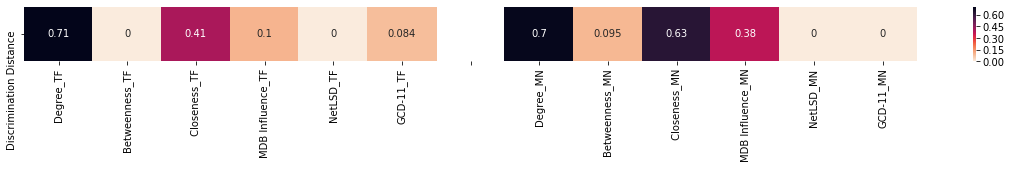

In [103]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

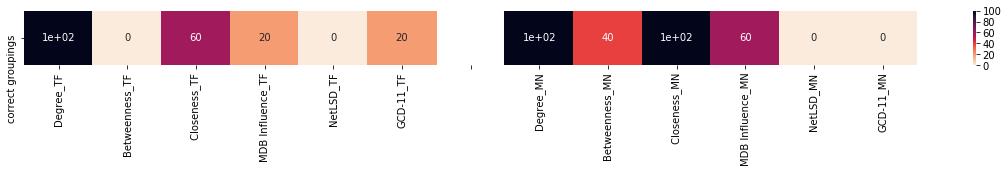

In [104]:
# Correct Clustering Percentage
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

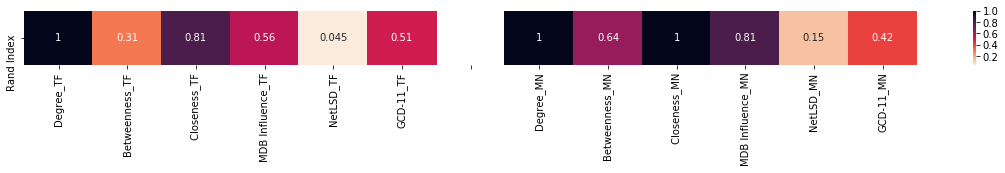

In [105]:
# Adjusted Rand Index
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised Statistical Analysis

The datasets that will be analyzed:

In [106]:
datasets = {'TF_degree': degree_TF, 'TF_betweenness': betw_TF, 'TF_closeness' : closeness_TF, 'TF_MDB Inf.': MDBs_TF,
           'TF_NetLSD': heat_TF, 'TF_GCD-11': corrMat_TF,
           'MN_degree': degree_MN, 'MN_betweenness': betw_MN, 'MN_closeness' : closeness_MN, 'MN_MDB Inf.': MDBs_MN, 
           'MN_NetLSD': heat_MN, 'MN_GCD-11': corrMat_MN}

For the rest of the notebook, only the 'TF' secondary datasets will be analysed as to mimic the images in the dissertation

The results starting with either the 'TF' or 'MN' networks are similar, leading to the same conclusions.

Furthermore, The NetLSD metric will also be removed.

In [107]:
datasets = {'Degree': degree_TF, 'betweenness': betw_TF, 'closeness' : closeness_TF, 'MDB Inf.': MDBs_TF,
           'GCD-11': corrMat_TF} #'TF_NetLSD': heat_TF, 

## Random Forests

### Test number of trees needed for predictive accuracy convergence for the different secondary datasets

Random Forest models with different number of trees will be built to assess when the predictive accuracy of the different models stops increasing with higher number of trees.

In [108]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
# Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,400,10)} # Models will be built from 10 to 400 trees in 10 tree intervals.

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv = 3)

In [109]:
param = []
test_score = []

# For each dataset,building the Random Forest models with the different number of trees
# and storing the predictive accuracy (estimated by 3-fold cross-validation)
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting Degree ... Done!
Fitting betweenness ... Done!
Fitting closeness ... Done!
Fitting MDB Inf. ... Done!
Fitting GCD-11 ... Done!


#### Part of Suppl. Fig. 6.10

Text(0.5, 1.0, 'Yeast Dataset')

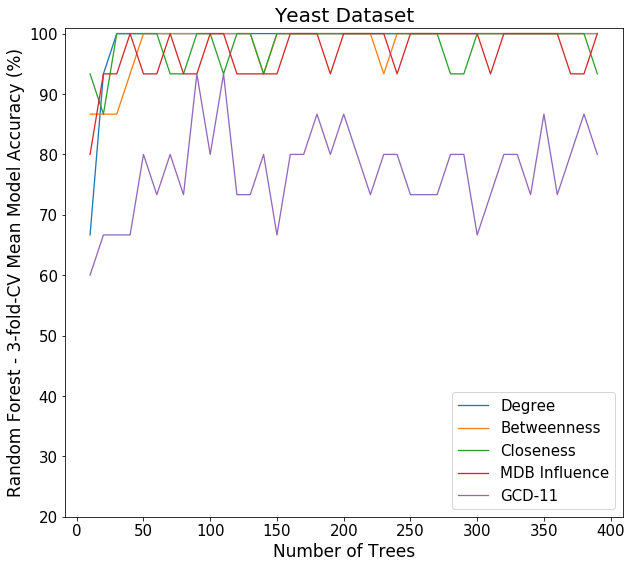

In [110]:
# Plotting the results and adjusting parameters of the plot
f, ax = plt.subplots(figsize=(10,9))
for i in range(5):
    plt.plot(param[i], test_score[i]*100)
plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('Degree', 'Betweenness', 'Closeness', 'MDB Influence', 'GCD-11'), fontsize=15, loc='lower right')
plt.ylim(20,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Yeast Dataset', fontsize=20)

### Random Forest Application

Stores predictive accuracy of the models, standard deviation of the predictive accuracy (across th iterations) and an ordered list of the most to least important features in building the model according to the Gini Importance calculated by scikit-learn (all estimated by straitified 3-fold cross-validation) of each of the 200 iterations (with different samplings of the 3 folds) of models built for each secondary dataset.

Use of the `simple_RF` function of multianalysis.py (uses Random Forest algorithm from scikit-learn) where each step of the process is better explained.


In [111]:
# Preparations of dicts:
Scores = {} # Stores Predictive Accuracy
Scores_std = {} # Stores Predictive Accuracy's Standard Deviation
Imp_feat = {} # Stores ordered list of most to least important feature to build the model


for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, iter_num = 200)
    
    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for Degree ...done
Fitting random forest for betweenness ...done
Fitting random forest for closeness ...done
Fitting random forest for MDB Inf. ...done
Fitting random forest for GCD-11 ...done


#### Performance of each predictive model - Part of Fig. 3.10

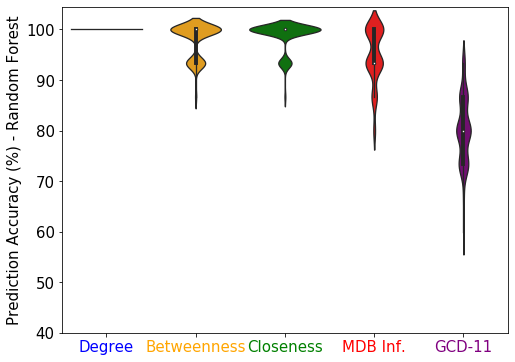

In [112]:
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# secondary dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(Scores) * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red','purple']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([40,104.5])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.savefig('Net-RF-YD')

#### Info for part of Fig. 3.10

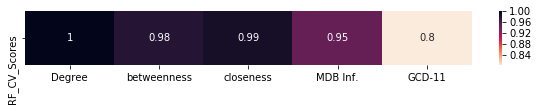

In [113]:
# Average prediction accuracy of the models built for each of the secondary datasets
# estimated by stratified 3-fold cross validation
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

# Plotting a heatmpa with the results
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

#### Important Features to build Random Forest models from MDB Influence secondary dataset - Part of Table 3.6

In [114]:
# Important MDBs to build the discriminatory Random Forest models
Imp_feat['MDB Inf.'] 
important_feat_RF = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
important_feat_RF = important_feat_RF.set_index('Place')
n=1
for i,j,m in Imp_feat['MDB Inf.']:
    important_feat_RF.loc[n]= m,j
    n = n+1
important_feat_RF

,MDB,Gini Importance
Place,,
1,PO3H,0.086069
2,CO,0.082987
3,S,0.080730
4,CH2,0.080538
5,O,0.077935
6,CO2,0.077280
7,H2,0.074047
8,NH3(-O),0.074024
9,CONH,0.071363


## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

In [115]:
matrix = pd.get_dummies(all_labels)
matrix

,BY4741,dENO1,dGLO1,dGLO2,dGRE3
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,1,0,0,0
7,0,1,0,0,0
8,0,1,0,0,0
9,0,0,1,0,0


### Optimization - Search for the best number of components to use - Part of Suppl. Fig 6.11

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predcited regression vector (one value for each group) obtained for a test sample (ypred). 

The number of components were optimized by observing the score metric of the PLSRegression of scikit learn, that is, the 1 - PRESS/SS or Q2 of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares
SS - residual Sum of Squares

To observe details of the `optim_PLS` function used to build the models and extract results, see multianalysis.py file. 

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [116]:
%%capture --no-stdout
# Build and extract metrics from models build with different number of components by using the optim_PLS function.
PLS_optim = {}
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 7)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for Degree ...done
Optimizing PLS-DA for betweenness ...done
Optimizing PLS-DA for closeness ...done
Optimizing PLS-DA for MDB Inf. ...done
Optimizing PLS-DA for GCD-11 ...done


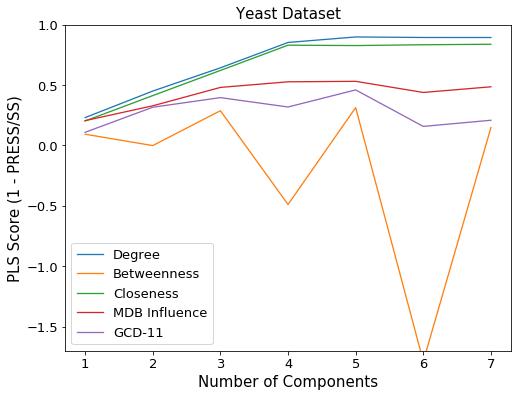

In [117]:
# Plotting the results
f, ax = plt.subplots(figsize=(8,6))
for name, data in PLS_optim.items():
    plt.plot(range(1,8),data)
    
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
plt.ylim([-1.7, 1])
plt.title('Yeast Dataset', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(('Degree', 'Betweenness', 'Closeness', 'MDB Influence', 'GCD-11'), fontsize=13)
           #'MN_Degree', 'MN_Betweenness', 'MN_Closeness', 'MN_MDBs', 'MN_Heat', 'MN_GCD-11'))
plt.show()

5 components were used for the PLS-DA model made after.

### Application of PLS-DA - Part of Fig. 3.10

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection) - used in dissertation (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [118]:
# Dictionaries to store results
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [119]:
%%capture --no-stdout

# For each secondary dataset, fit PLS-DA models with 5 components on 200 randomly sampled folds (for stratified 3-fold cross
# validation. Store results in dictionaries (results for 200 iterations).
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 5, iter_num = 200, feat_type = 'VIP')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done') 

Fitting PLS-DA for Degree ...done
Fitting PLS-DA for betweenness ...done
Fitting PLS-DA for closeness ...done
Fitting PLS-DA for MDB Inf. ...done
Fitting PLS-DA for GCD-11 ...done


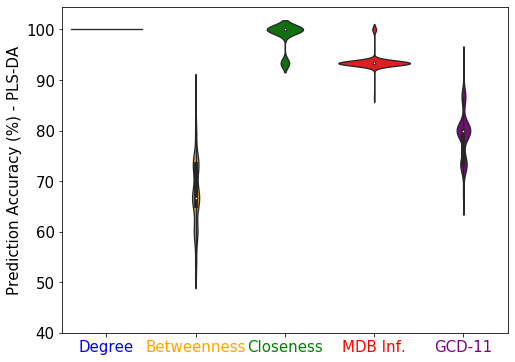

In [120]:
# Plot the distribution of prediction accuracy of the 200 iterations of models built from each of the secondary datasets
# Part of Fig. 3.10
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(PLS_accu) * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red', 'purple']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([40,104.5])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
    
#plt.savefig('Net-PLSDA-YD')

In [121]:
# Average prediction accuracy of the models built for each of the secondary datasets
# estimated by stratified 3-fold cross validation
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Score[name] = np.mean(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

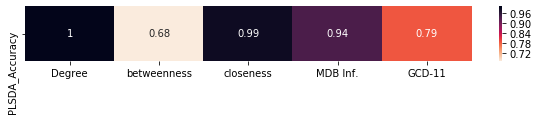

In [122]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])
plt.show()

#### Important Features to build PLS-DA models from MDB Influence secondary dataset

In [123]:
# Important MDBs to build the PLS-DA Models
PLS_feat['MDB Inf.'] 
important_feat_PLSDA  = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
important_feat_PLSDA = important_feat_PLSDA.set_index('Place')
n=1
for i,j,m in PLS_feat['MDB Inf.']:
    important_feat_PLSDA.loc[n]= m,j
    n = n+1
important_feat_PLSDA

,MDB,Gini Importance
Place,,
1,CH2,1.569590
2,CO2,1.455744
3,H2,1.371437
4,O,1.255234
5,PO3H,1.230180
6,C2H2O,1.139284
7,CO,1.022441
8,NCH,0.878879
9,NH3(-O),0.770066


## Conclusions - Main Discussion of the Results made in the Dissertation

- Results are very similar using these MDiN's constructed with MetaNetter to the networks made with the assigned formulas (Formula_Networks.ipynb file).
- Centrality measures make an almost perfect discrimination while topology centered methods and group influences have slightly worse performances.
- No formula assignment is needed for this analysis. Possible drawback is not accounting for the usual elemental ratios constraint (continuous adding of certain groups) but since we want to look at an estimation of the chemcial diversity of the sample represented by the topology of a network, this probably isn't a major drawback.
- No necessary formula assignment makes it possible to analyze the Grapevine dataset also in this way.


## Permutation Tests - Part of Suppl. Fig. 6.12

Permutation tests were made for both the Random Forest and PLS-DA models with 1000 permutations to assess the significance of the predictive accuracy results. 

Initially, permutation tests were made for both the MDiNs made with our transformation list (TF) and MetaNetter's transformation list (MN), however, as was done for the rest of the supervised statistical analyses, only the results for the MDiNs made with our transformation list (TF) are now shown.

### Permutation Tests - Random Forests (very slow)

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [124]:
# Store results
CV = {}
PMs = {}
pvalue = {}

#all_data = (degree_TF, betw_TF, closeness_TF, MDBs_TF, heat_TF, corrMat_TF,
#           degree_MN, betw_MN, closeness_MN, MDBs_MN, heat_MN, corrMat_MN,)
#names = ('TF_Degree', 'TF_Betweenness', 'TF_Closeness', 'TF_MDBs', 'TF_Heat', 'TF_GCD-11',
#           'MN_Degree', 'MN_Betweenness', 'MN_Closeness', 'MN_MDBs', 'MN_Heat', 'MN_GCD-11')

all_data = (degree_TF, betw_TF, closeness_TF, MDBs_TF, corrMat_TF)
names = ('Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11')

# Application of permutations tests (with 1000 iterations)
for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=1000, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Degree ...
Done!
Permutation test (Random Forest) for Betweenness ...
Done!
Permutation test (Random Forest) for Closeness ...
Done!
Permutation test (Random Forest) for MDB Inf. ...
Done!
Permutation test (Random Forest) for GCD-11 ...
Done!


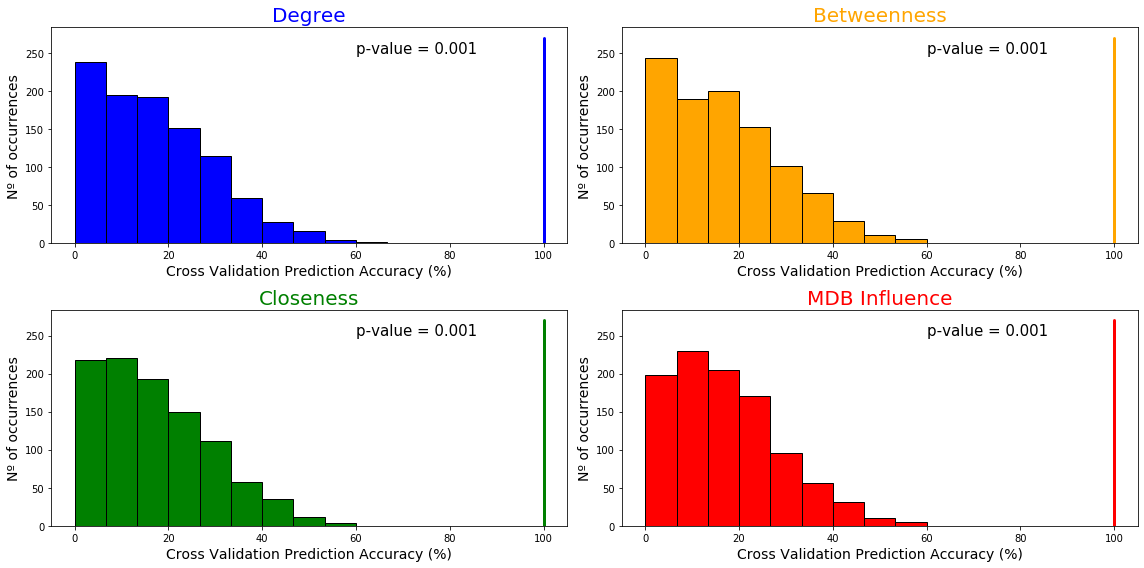

In [125]:
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy - 'Degree', 'Betweenness', 'Closeness', 'MDB Inf.' secondary datasets.
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.']
colors = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,270]
n_labels = len(degree_TF.cdl.labels) # Equal between all datasets

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(60,250, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    if name == 'MDB Inf.':
        name = 'MDB Influence'
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Net-Perm-YD-RF')

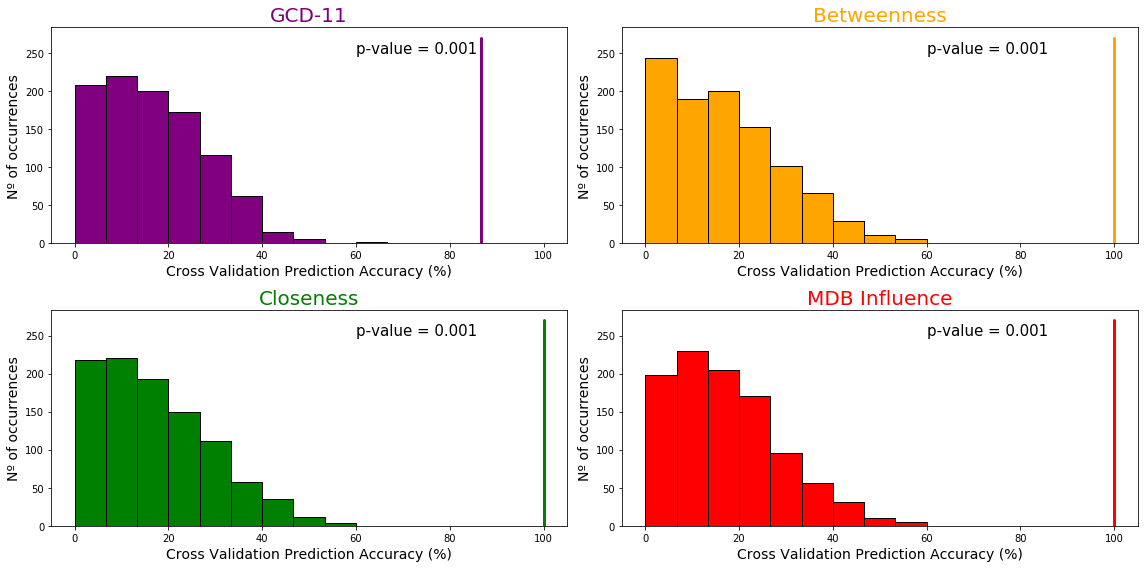

In [126]:
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy - only the 'GCD-11' part of the plot is new information
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['GCD-11', 'Betweenness', 'Closeness', 'MDB Inf.']
colors = ['purple', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,270]
n_labels = len(degree_TF.cdl.labels) # Equal between all datasets

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(60,250, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    if name == 'MDB Inf.':
        name = 'MDB Influence'
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Net-Perm-YD-RF2')

### Permutation Tests - PLS-DA (slow)

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [127]:
# Store Results
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

#all_data = (degree_TF, betw_TF, closeness_TF, MDBs_TF, heat_TF, corrMat_TF,
#           degree_MN, betw_MN, closeness_MN, MDBs_MN, heat_MN, corrMat_MN,)
#names = ('TF_Degree', 'TF_Betweenness', 'TF_Closeness', 'TF_MDBs', 'TF_Heat', 'TF_GCD-11',
#           'MN_Degree', 'MN_Betweenness', 'MN_Closeness', 'MN_MDBs', 'MN_Heat', 'MN_GCD-11')

all_data = (degree_TF, betw_TF, closeness_TF, MDBs_TF, corrMat_TF)
names = ('Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11')

# Application of permutations tests (with 1000 iterations)
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=5, iter_num=1000)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Degree ...
Done!
permutation test (PLS-DA) for Betweenness ...
Done!
permutation test (PLS-DA) for Closeness ...
Done!
permutation test (PLS-DA) for MDB Inf. ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for GCD-11 ...
Done!


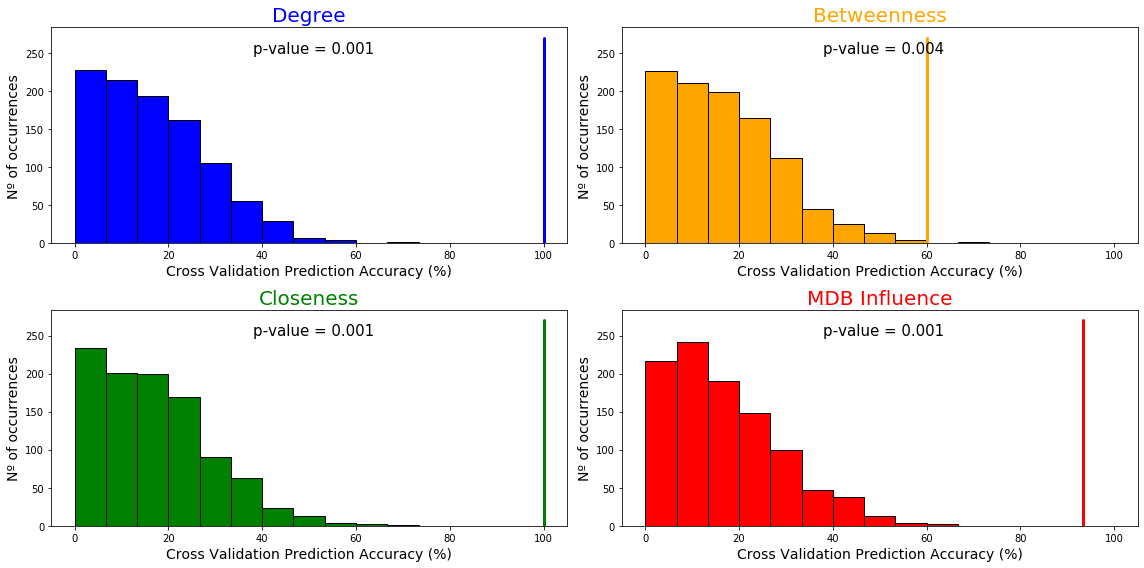

In [128]:
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy - 'Degree', 'Betweenness', 'Closeness', 'MDB Inf.' secondary datasets.
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.']
colors = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,270]
n_labels = len(degree_TF.cdl.labels) # Equal between all datasets

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(38,250, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    if name == 'MDB Inf.':
        name = 'MDB Influence'
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Net-Perm-YD-PLSDA')

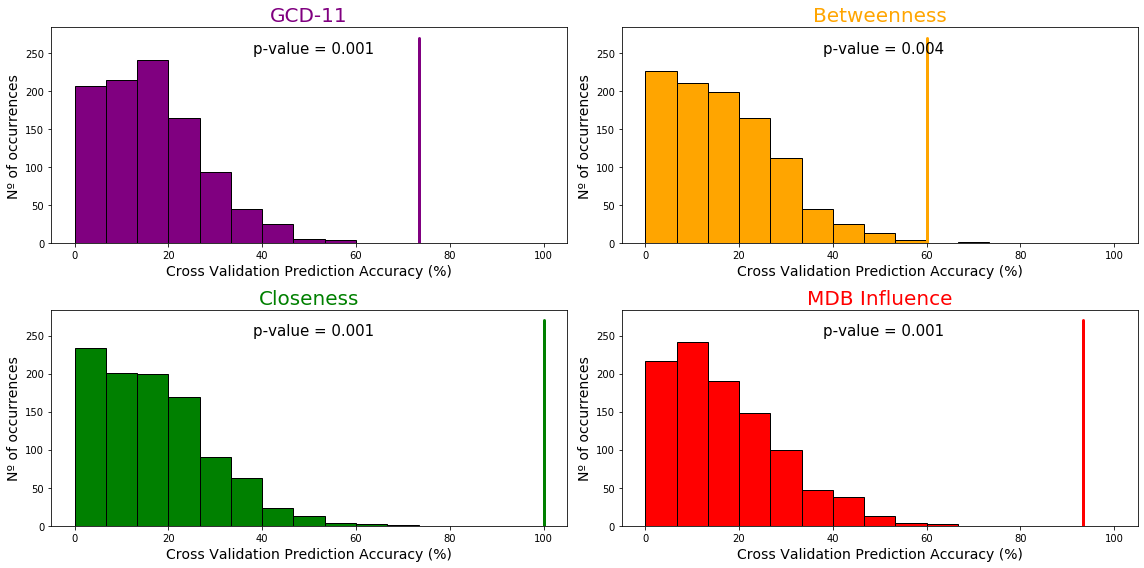

In [129]:
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy - only the 'GCD-11' part of the plot is new information
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['GCD-11', 'Betweenness', 'Closeness', 'MDB Inf.']
colors = ['purple', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,270]
n_labels = len(degree_TF.cdl.labels) # Equal between all datasets

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(38,250, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    if name == 'MDB Inf.':
        name = 'MDB Influence'
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Net-Perm-YD-PLSDA2')

### See if sample MDiNs built from scratch and induced subgraph are isomorphic

In [130]:
# Write files with the data of the list of masses that appear in each sample

#for j in yeast_df.columns[3:]:
#    df = yeast_df[yeast_df.loc[:,j] != 0] # Selecting the formulas that actually appear in each sample
#    title = 'Net_' + str(j) + '.csv'
#    pd.DataFrame(df.index, columns=['Nodes'], index=df.index).to_csv(title)
#    #formula_df.index = df['Formula'] # Using the 'string' formulas as indexes
#df

From the file obtained of replicate nº 1, a MDiN was built using MetaNetter plugin of Cytoscape and exported under the name 'Net_BY0_1.graphml'.

Now, a comparison will be made between this network and the network induced from the original complete yeast network

In [131]:
# Read sample MDiN 
BY01 = nx.read_graphml('Net_YD_BY0_1.graphml').to_undirected()
len(BY01.nodes())

673

In [132]:
# Repeat the treatment made on other networks to the sample MDiN

# Give intensity and formula data to nodes and rename nodes to be represented by their mass
nx.get_node_attributes(BY01,'mass')
new_nodes = dict.fromkeys(BY01.nodes(),0)
formula_attr = dict.fromkeys(BY01.nodes(),0)
intensity_attr = dict.fromkeys(BY01.nodes(),0)
for i,j in nx.get_node_attributes(BY01,'mass').items():
    #print(i,j)
    formula_attr[i] = {'formula':yeast_df.loc[j,'Formula']}
    intensity_attr[i] = {'intensity':yeast_df.loc[j,'BY0_1']}
    new_nodes[i] = j
nx.set_node_attributes(BY01,intensity_attr)
BY01 = nx.relabel_nodes(BY01, mapping=new_nodes)
#BY01.nodes()[743.4413052682]

In [133]:
# MDB Influence in building the network - BY01 (built from scratch)
BY01_MDBs = dict.fromkeys(MDBs, 0)
for i in BY01.edges():
    #print(i)
    BY01_MDBs[BY01.edges()[i]['Transformation']] = BY01_MDBs[BY01.edges()[i]['Transformation']] + 1
BY01_MDBs

{'H2': 33,
 'CH2': 66,
 'CO2': 16,
 'O': 37,
 'CHOH': 0,
 'NCH': 11,
 'O(-NH)': 11,
 'S': 4,
 'CONH': 6,
 'PO3H': 19,
 'NH3(-O)': 11,
 'SO3': 1,
 'CO': 29,
 'C2H2O': 13,
 'H2O': 31}

In [134]:
# Sample MDiN from inducing the subgraph of the complete Yeast MDiN
BY01_ot = NetTF.subgraph(yeast_df[yeast_df.iloc[:,3] != 0].index)
len(BY01_ot)

673

In [135]:
# MDB Influence in building the network - BY01_ot (induced from complete Yeast MDiN)
BY01_ot_MDBs = dict.fromkeys(MDBs, 0)
for i in BY01_ot.edges():
    #print(i)
    BY01_ot_MDBs[BY01_ot.edges()[i]['Transformation']] = BY01_ot_MDBs[BY01_ot.edges()[i]['Transformation']] + 1
BY01_ot_MDBs

{'H2': 33,
 'CH2': 66,
 'CO2': 16,
 'O': 37,
 'CHOH': 0,
 'NCH': 11,
 'O(-NH)': 11,
 'S': 4,
 'CONH': 6,
 'PO3H': 19,
 'NH3(-O)': 11,
 'SO3': 1,
 'CO': 29,
 'C2H2O': 13,
 'H2O': 31}

Comparing number of nodes in each component and testing if the networks are isomorphic

In [136]:
[len(c) for c in sorted(nx.connected_components(BY01), key=len, reverse=True)][:20]

[96, 23, 10, 9, 7, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3]

In [137]:
[len(c) for c in sorted(nx.connected_components(BY01_ot), key=len, reverse=True)][:20]

[96, 23, 10, 9, 7, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3]

In [138]:
nx.is_isomorphic(BY01,BY01_ot)

True